






## 1.常数

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.colors as mcolors
from scipy.integrate import quad 
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded  ##用于求解线性方程组
from scipy.optimize import fsolve
import scipy.sparse
import scipy.sparse.linalg
from numpy import linspace, zeros, random, array
import time, sys
from mpl_toolkits.mplot3d import Axes3D
import scipy.interpolate
from matplotlib.colors import LogNorm
from itertools import cycle
from matplotlib.colors import Normalize
# constants  unit cgs
c = 29979245800.0 # speed of light
M_sun = 1.9891e33 # mass of sun
R_sun = 6.961e10 ## radius of sun
a_rad =7.56566*10**(-15) # radiation constant
pi = np.pi
sigma_SB=5.67032*10**(-5) # S-B constant
sigma_T=6.652448*10**(-25.0) # Thomson scattering cross
m_p=1.6726485*10**(-24.0) # mass of proton
m_e=9.109534*10**(-28.0) # mass of electron
q_e = 4.803242*10**(-10) #charge of electron
eV =1.6*10**(-12) ## eV in unit of erg  
km=10**5
day=3600*24.0
pc=3.08567756*10**(18.0)
Mpc=10**(6)*pc
hp=6.626176*10**(-27.0) #Planck constant
kb=1.380662*10**(-16.0) # Bolztmann constant
uJy=10**(-29.0)
mJy=10**(-26.0)
Jy=10**(-23.0)
yr=365*24*3600.0
GHz =1.0e9
H0 = 70.0*km/Mpc
nm = 1e-7
Omega_m = 0.30
Omega_L = 0.70
lambda_B = 440*nm 
lambda_g = 470*nm 
lambda_V = 545*nm 
lambda_R = 640*nm 
lambda_i = 790*nm

nu_g = c/lambda_g 
nu_R= c/lambda_R 
nu_FUV = 2e15 
nu_V =c /lambda_V
nu_i = c/lambda_i
nu_B = c/lambda_B


tau_Ni =8.8*day
tau_Co = 111.3*day
eNi = 3.9e10 ## specific heating rate of Ni
eCo = 6.8e9 ## specific heating rate of Co
eCo_ratio = eCo /(eNi - eCo) # Co 沉积率比例

# =========================
# 1. 字体与渲染设置（避免LaTeX依赖）
# =========================
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],  # 回退字体
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 10,
    "axes.titlesize": 18
})

In [2]:


class SupernovaLightCurve:
    """
    A simple illustrative numerical model for supernova light curves.
    """

    def __init__(self):
        # Fundamental constants
        self.pi = np.pi
        self.c = 3.0e10                    # Speed of light (cm/s)
        self.sigma_SB = 5.670374419e-5     # Stefan-Boltzmann constant (erg cm^-2 s^-1 K^-4)
        self.a_rad = 7.5646e-15            # Radiation constant (erg cm^-3 K^-4)
        self.kb = 1.380649e-16             # Boltzmann constant (erg/K)
        self.hp = 6.62607015e-27           # Planck constant (erg s)
        self.pc = 3.086e18                 # 1 parsec (cm)
        self.day = 86400.0                 # number of seconds in one day

        # Example Ni/Co decay energy deposition rates
        self.eNi = 3.9e10  # erg/s/g (Nickel)
        self.eCo = 6.8e9   # erg/s/g (Cobalt)
        # Example decay timescales
        self.tau_Ni = 8.8 * self.day
        self.tau_Co = 111.4 * self.day

    def calculate_light_curve(self,
                              nu_obs=nu_R,
                              M_ej = 5.0*M_sun,
                              E_K =1.0e51,
                              E_Th_in =1.0e49, 
                              M_Ni = 0.2*M_sun,
                              kappa0=0.3,
                              R_max_in=1.0e12,
                              x_max=1.0e4,
                              x_s=0.2,
                              Nx=100,
                              Ny=2000,
                              eta_ej_func=None):
        """
        Calculate the supernova light curve using a simplified PDE model.

        Parameters
        ----------
        nu_obs : float
            Observed frequency (Hz).
        M_ej : float
            Total ejecta mass (g).
        E_K : float
            Total kinetic energy (erg).
        E_Th_in : float
            Initial thermal energy (erg).
        M_Ni : float
            Nickel mass (g).
        kappa0 : float
            Mean opacity (cm^2 g^-1).
        R_max_in : float
            Initial outer radius (cm).
        x_max : float
            Maximum dimensionless radius.
        x_s : float
            Fraction of x_max within which nickel is distributed (0 <= x <= x_s*x_max).
        Nx : int
            Number of radial grid points.
        Ny : int
            Number of temporal grid points.
        eta_ej_func : callable, optional
            A custom radial density profile function, shape: eta_ej_func(x).
            If None, a simple linear-decreasing profile is used.

        Returns
        -------
        t_days : ndarray
            Time array in days, shape = (Ny,).
        L_bol_values : ndarray
            Bolometric luminosity as a function of time, shape = (Ny,).
        L_heat_values : ndarray
            Radioactive heating rate from Ni/Co decay, shape = (Ny,).
        x_vals_new : ndarray
            Dimensionless radial grid, x_vals / x_max, shape = (Nx+1,).
        e_values : ndarray
            Dimensionless internal energy distribution, shape = (Nx+1, Ny).
        T_values : ndarray
            Temperature distribution (K), shape = (Nx+1, Ny).
        T_eff_values : ndarray
            Photospheric temperature (K) as a function of time, shape = (Ny,).
        M_ab_values : ndarray
            Absolute magnitude (approximate) as a function of time, shape = (Ny,).
        """

        pi = self.pi
        day = self.day
        c = self.c
        a_rad = self.a_rad
        sigma_SB = self.sigma_SB

        # 1) If eta_ej_func is not provided, use a simple linear profile
        if eta_ej_func is None:
            def eta_ej_func(x):
                return 1.0 - 0.01 * x / x_max

        # 2) Dimensionless radius limits
        x_min = 1.0
        x_heat = x_s * x_max  # nickel distribution cutoff

        # 3) Compute integrals for total mass and kinetic energy factors
        def Int_I_M(x):
            return x*x * eta_ej_func(x)

        def Int_I_K(x):
            return x**4 * eta_ej_func(x)

        I_M = quad(Int_I_M, x_min, x_max, epsabs=1e-5, limit=100)[0]
        I_K = quad(Int_I_K, x_min, x_max, epsabs=1e-5, limit=100)[0]

        # 4) Characteristic scales
        #    - R_min_in: radius corresponding to x=1
        #    - rho_in: average density scale at the inner boundary
        R_min_in = R_max_in / x_max
        rho_in = M_ej / (4.0 * pi * I_M * R_min_in**3)

        #    - v_min: velocity at x=1
        #    - t_ex: expansion timescale
        v_min = np.sqrt(2.0 * I_M * E_K / (I_K * M_ej))
        t_ex = R_min_in / v_min

        #    - t_diff: photon diffusion timescale
        t_diff = 3.0 * kappa0 * rho_in * R_min_in**2 / c

        #    - dimensionless reference for internal energy
        #      e_heat0: (Ni - Co) energy deposition rate per unit mass
        e_heat0 = (self.eNi - self.eCo)
        eCo_ratio = self.eCo / (self.eNi - self.eCo)
        u0 = rho_in * e_heat0 * t_diff  # scale factor to convert dimensionless e-values to physical energy density

        #    - L0: scale factor for luminosity (used in a rough estimate at the outer boundary)
        L0 = (4.0 * pi * R_min_in * c * u0) / (3.0 * kappa0 * rho_in)
        tau_in = kappa0 * rho_in * R_min_in

        # 5) Initial internal energy distribution e0(x)
        def e_initial(x):
            """
            Dimensionless initial internal energy distribution, ~ 1/x.
            The coefficient below can be adjusted for specific physical scenarios.
            """
            e0 = E_Th_in / (2.0 * pi * u0 * x_max**2 * R_min_in**3)
            return e0 / x

        # 6) Auxiliary functions
        def f_R(y):
            """
            Dimensionless radius ratio: R(t) / R(0) = 1 + (t/t_ex).
            Here t = y * t_diff, so f_R(y) = 1 + (y*t_diff / t_ex).
            """
            return 1.0 + (y * t_diff / t_ex)

        def R_max_func(y):
            """
            Outer radius as a function of dimensionless time y.
            Physical time t = y * t_diff.
            R(t) = R_min_in * x_max + v_min * x_max * t.
            """
            t_phys = y * t_diff
            return R_min_in * x_max + v_min * x_max * t_phys

        def f_heat(y):
            """
            Radioactive heating factor (Ni and Co), dimensionless time y => t = y*t_diff.
            Ni -> exp(-t/tau_Ni), Co -> exp(-t/tau_Co).
            """
            t_phys = y * t_diff
            return np.exp(-t_phys / self.tau_Ni) + eCo_ratio * np.exp(-t_phys / self.tau_Co)

        # 7) Nickel distribution (uniform in x < x_heat)
        denom = quad(Int_I_M, x_min, x_heat, epsabs=1e-5, limit=100)[0]
        xi0 = (I_M * M_Ni / M_ej) / denom

        def xi_heat_func(x_array):
            """
            Returns an array of nickel fraction xi for each x in x_array.
            Nickel is uniformly distributed up to x_heat.
            """
            out = np.zeros_like(x_array)
            mask = (x_array >= x_min) & (x_array <= x_heat)
            out[mask] = xi0
            return out

        # 8) Discretization in space and time
        x_vals = np.linspace(x_min, x_max, Nx+1)
        dx = (x_max - x_min) / Nx

        t_max = 500 * day  # e.g., compute up to 300 days
        y_max = t_max / t_diff
        y_vals = np.linspace(0.0, y_max, Ny+1)
        dy = y_vals[1] - y_vals[0]

        # 9) Allocate solution arrays
        e_values = np.zeros((Nx+1, Ny+1))  # dimensionless internal energy
        T_values = np.zeros((Nx+1, Ny+1))  # temperature
        L_bol_values = np.zeros(Ny+1)      # total/bolometric luminosity
        L_heat_values = np.zeros(Ny+1)     # Ni/Co decay heating rate
        T_eff_values = np.zeros(Ny+1)      # photospheric temperature
        M_ab_values = np.zeros(Ny+1)       # absolute magnitude

        # Initial condition
        e_values[:, 0] = e_initial(x_vals)

        # 10) Prepare arrays for tridiagonal solver
        diagonal = np.zeros(Nx+1)
        lower = np.zeros(Nx)
        upper = np.zeros(Nx)
        b_vec = np.zeros(Nx+1)

        # Pre-calculate eta_ej and xi_heat at each spatial point
        eta_vals = eta_ej_func(x_vals)
        xi_vals = xi_heat_func(x_vals)

        # Helper for the outer boundary condition
        def f_ob(y_):
            """
            Outer boundary factor f_ob(y).
            Used for boundary condition at x = x_max (i = Nx).
            """
            return -(2.0 / (3.0 * tau_in * eta_ej_func(x_max))) * (f_R(y_))**2

        # 11) Time stepping loop
        for n in range(Ny):
            y_now = y_vals[n]
            y_next = y_vals[n+1]

            # Next-time step expansions
            fR_next = f_R(y_next)
            # D_eff at y_next
            D_next = (x_vals**2 / eta_vals) * fR_next

            # Current-time expansions
            fR_now = f_R(y_now)
            D_now = (x_vals**2 / eta_vals) * fR_now

            # S(x, y): the source (Ni/Co) at current and next times
            S_now = fR_now * eta_vals * xi_vals * f_heat(y_now)
            S_next = fR_next * eta_vals * xi_vals * f_heat(y_next)

            # Set up the tridiagonal matrix for Crank-Nicolson
            x_inner = x_vals[1:-1]
            mu_val = 0.25 * dy / (x_inner * dx)**2

            diag_mid = mu_val * (D_next[2:] + 2.0 * D_next[1:-1] + D_next[:-2])
            diagonal[1:-1] = 1.0 + diag_mid

            lower[:-1] = -mu_val * (D_next[1:-1] + D_next[:-2])
            upper[1:] = -mu_val * (D_next[2:] + D_next[1:-1])

            # Boundary conditions
            # Left (i=0)
            diagonal[0] = -1.0
            upper[0] = 1.0
            # Right (i=Nx)
            diagonal[Nx] = dx - f_ob(y_next)
            lower[-1] = f_ob(y_next)

            # Assemble the sparse matrix
            A = scipy.sparse.diags(
                [diagonal, lower, upper],
                offsets=[0, -1, 1],
                shape=(Nx+1, Nx+1),
                format='csr'
            )

            # Right-hand side b
            e_now = e_values[:, n]
            b_vec[1:-1] = (
                e_now[1:-1]
                + 0.5 * dy * (S_now[1:-1] + S_next[1:-1])
                + mu_val * (
                    (D_now[2:] + D_now[1:-1]) * (e_now[2:] - e_now[1:-1])
                    - (D_now[1:-1] + D_now[:-2]) * (e_now[1:-1] - e_now[:-2])
                )
            )
            b_vec[0] = 0.0
            b_vec[Nx] = 0.0

            # Solve the linear system for e[:, n+1]
            e_values[:, n+1] = scipy.sparse.linalg.spsolve(A, b_vec)

            # 12) Compute temperature, luminosity, etc. at time step n+1
            e_next = e_values[:, n+1]
            T_values[:, n+1] = (1.0 / fR_next) * ((e_next * u0 / a_rad))**0.25

            # Bolometric luminosity (rough estimate)
            # L_bol ~ L0 * ( x_max^2 / eta_ej(x_max) ) * [ e(Nx-1) - e(Nx) ] / dx
            L_bol_values[n+1] = L0 * (x_max**2 / eta_ej_func(x_max)) \
                                * (e_next[Nx-1] - e_next[Nx]) / dx

            # Photospheric temperature
            R_outer = R_max_func(y_next)
            T_eff_values[n+1] = (L_bol_values[n+1] / (4.0 * pi * R_outer**2 * sigma_SB))**0.25

            # Approximate absolute magnitude in a single band
            T_floor = 2000.0
            T_for_calc = max(T_eff_values[n+1], T_floor)
            x_obs = self.hp * nu_obs / (self.kb * T_for_calc)
            B_nu = 2.0 * self.hp * nu_obs**3 / self.c**2 / (np.exp(x_obs) - 1.0)
            L_nu = 4.0 * pi * pi * R_outer**2 * B_nu
            F_nu = L_nu / (4.0 * pi * (10.0 * self.pc)**2)
            # Magnitude
            M_ab_values[n+1] = -2.5 * np.log10(F_nu) - 48.6

            # Ni/Co heating rate (just for reference)
            L_heat_values[n+1] = M_Ni * (self.eNi - self.eCo) * f_heat(y_next)

        # 13) Convert time array to days, and remove the step 0 if desired
        t_days = y_vals * (t_diff / day)

        # Strip the t=0 data if desired, or keep them for completeness
        t_days = t_days[1:]
        L_bol_values = L_bol_values[1:]
        L_heat_values = L_heat_values[1:]
        T_eff_values = T_eff_values[1:]
        M_ab_values = M_ab_values[1:]
        T_values = T_values[:, 1:]

        # Dimensionless radial grid
        x_new = x_vals / x_max

        return t_days,L_bol_values,L_heat_values,x_new, T_values, T_eff_values, M_ab_values
     
    def Arnett_light_curve(self,
                              nu_obs= nu_R,
                              M_ej= 5.0*M_sun,
                              E_K= 1.0e51,
                              E_Th_in= 1.0e49,
                              M_Ni= 0.2*M_sun,
                              kappa0=0.2,
                              R_max_in=100*R_sun,
                              ):
        """
        计算超新星光变曲线。

        参数：
        -------
        nu_obs   : float，观测频率（默认取 R 波段的频率）
        M_ej     : float，喷发物总质量，默认 5.0 个太阳质量
        E_K      : float，总动能 (erg)，默认 1e51 erg
        E_Th_in  : float，初始热能 (erg)，默认 1e49 erg
        M_Ni     : float，镍质量，默认 0.5 个太阳质量
        kappa0   : float，平均不透明度 (cm^2 g^-1)，默认 0.2
        R_max_in : float，初始最外层半径 (cm)，默认 1e9
        """
        Nt = 500 ## number of time steps
        Nx = 100 ## 
        t_vals = np.linspace(0.00,500,Nt)*day
        x_vals = np.linspace(0.001,1,Nx)
        v_ej = (2.0 * E_K / M_ej)**0.5 ## typical ejecta velocity
        t_diff = (2.0 * kappa0*M_ej/(13.8*v_ej*c))**(0.5) ## Arnett diffusion time scale
        tau_diff= (2.0*kappa0*M_ej/(13.8*v_ej*v_ej))**(0.5) ## Arnett diffusion time scale
        y_vals = t_vals/t_diff ## dimensionless time
        y_tau =tau_diff/t_diff ##无量纲变成透明的时间
        L_bol_Arnett = np.zeros(Nt)
        T_vals_Arnett = np.zeros((Nx,Nt))
        def f_heat(y): ##归一化的镍的加热率
            t = y*t_diff
            return np.exp(-t / tau_Ni) + eCo_ratio * np.exp(- t /tau_Co) 
        def Int_I_LC(x):
            return x*np.exp(x**2.0) *f_heat(x) 
        for n, y in enumerate(y_vals):
            if y <2.0*y_tau:
                I_LC= quad(Int_I_LC, 0,y, epsabs=1e-2, limit=100)[0]
                L_bol_Arnett[n] = 2.0*M_Ni*(eNi - eCo )*np.exp(-y**2.0) *I_LC
            else:
                L_bol_Arnett[n] = M_Ni*(eNi - eCo )*f_heat(y)
        R_ph = R_max_in + v_ej*t_vals
        T_eff_Arnett = (L_bol_Arnett/(4*pi*R_ph**2*sigma_SB))**0.25
        def f_T_Arnett(x):
            return (np.sin(0.99*pi*x)/(x*np.sin(0.99*pi)))**(0.25)
        Phi_T_Arnett = f_T_Arnett(x_vals) ## dimensionless temperature profile
        for n, y in enumerate(y_vals):  
            T_vals_Arnett[:,n] = T_eff_Arnett[n]*Phi_T_Arnett ## temperature profile
        t_days_Arnett = t_vals/day
        return t_days_Arnett,x_vals, L_bol_Arnett,T_eff_Arnett,T_vals_Arnett
            
    def Onezone_light_curve(self,
                              nu_obs= nu_R,
                              M_ej= 5.0*M_sun,
                              E_K= 1.0e51,
                              E_Th_in= 1.0e49,
                              M_Ni= 0.2*M_sun,
                              kappa0=0.2,
                              R_max_in=100*R_sun,
                              ):
        Nt = 500 ## number of time steps
        Nx = 100 ## 
        t_vals = np.linspace(0.0,500,Nt)*day
        x_vals = np.linspace(0.0001,1,Nx)
        v_ej = (2.0 * E_K / M_ej)**0.5 ## typical ejecta velocity
        t_diff = (3.0 * kappa0*M_ej/(2.0*pi*v_ej*c))**(0.5) ## one-zone diffusion time scale
        tau_diff= (3.0*kappa0*M_ej/(2.0*pi*v_ej*v_ej))**(0.5) ## one-zone diffusion time scale
        y_vals = t_vals/t_diff ## dimensionless time
        y_tau =tau_diff/t_diff ##无量纲变成透明的时间
        L_bol_onezone = np.zeros(Nt)
        def f_heat(y): ##归一化的镍的加热率
            t = y*t_diff
            return np.exp(-t / tau_Ni) + eCo_ratio * np.exp(- t /tau_Co) 
        def Int_I_LC(x):
            return x*np.exp(x**2.0) *f_heat(x) 
        for n, y in enumerate(y_vals):
            if y <2.0*y_tau:
                I_LC= quad(Int_I_LC, 0,y, epsabs=1e-4, limit=100)[0]
                L_bol_onezone[n] = 2*M_Ni*(eNi - eCo )*np.exp(-y**2.0) *I_LC
            else:
                L_bol_onezone[n] = M_Ni*(eNi - eCo )*f_heat(y)
        R_ph = R_max_in + v_ej*t_vals
        T_eff_onezone = (L_bol_onezone/(4*pi*R_ph**2*sigma_SB))**0.25
        def f_T_onezone(x):
            return ((1.01-x)/0.01)**(0.25)
        Phi_T_onezone = f_T_onezone(x_vals)
        T_vals_onezone = np.zeros((Nx,Nt))
        for n, y in enumerate(y_vals):  
            T_vals_onezone[:,n] = T_eff_onezone[n]*Phi_T_onezone
        t_days_onezone = t_vals/day
        return t_days_onezone,x_vals, L_bol_onezone,T_eff_onezone,T_vals_onezone


In [3]:
sn = SupernovaLightCurve()
t_days,L_bol_values,L_heat_values,x_new,  T_values, T_eff_values, M_ab_values = sn.calculate_light_curve(M_Ni=0.2*M_sun,x_s=0.11)
t_days_Arnett,x_vals, L_bol_Arnett,T_eff_Arnett,T_vals_Arnett = sn.Arnett_light_curve(M_Ni=0.2*M_sun)
t_days_onezone,x_vals, L_bol_onezone,T_eff_onezone,T_vals_onezone = sn.Onezone_light_curve(M_Ni=0.2*M_sun)

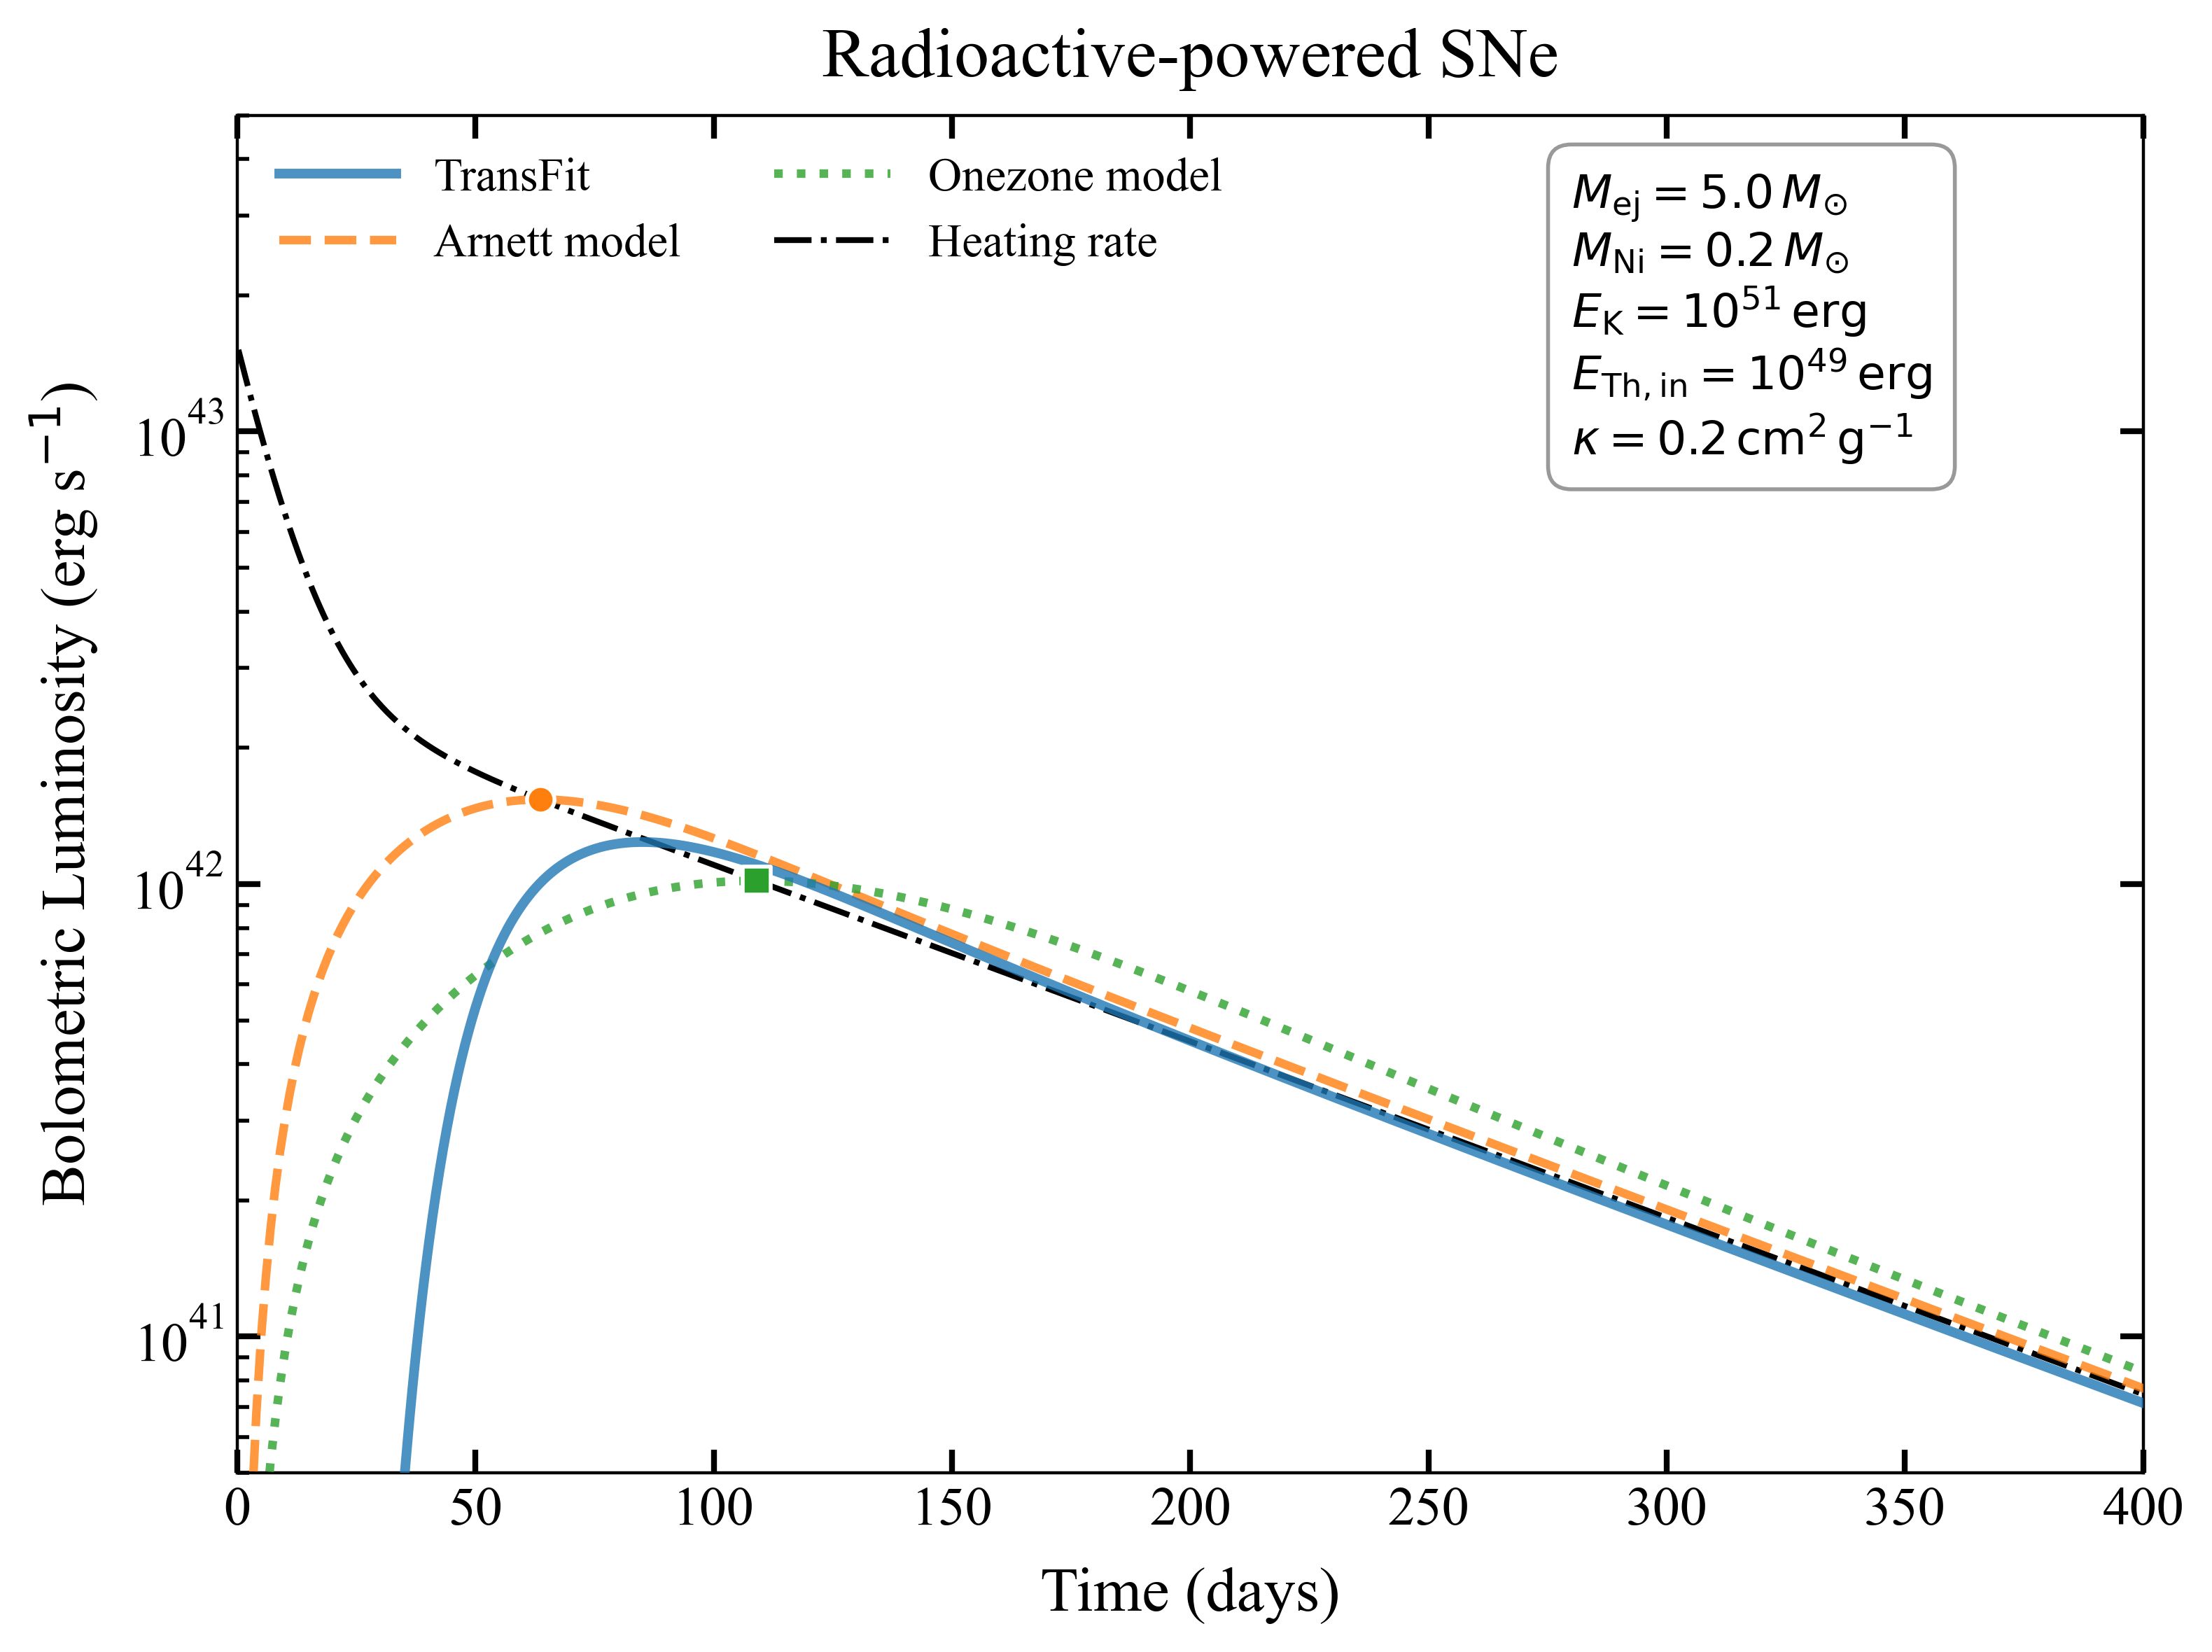

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 假设已有的时间和亮度数组：
# t_days, L_bol_values          -- our model
# t_days_Arnett, L_bol_Arnett  -- Arnett model
# t_days_onezone, L_bol_onezone-- One-zone model
# L_heat_values                 -- Heating rate (对应 t_days)

def find_intersection(t1, L1, t2, L2):
    """粗略找零点：在相邻点符号变化处线性插值求解"""
    # 在共同时间网格上插值
    t_common = np.linspace(max(t1.min(), t2.min()), min(t1.max(), t2.max()), 5000)
    L1i = np.interp(t_common, t1, L1)
    L2i = np.interp(t_common, t2, L2)
    sign = np.sign(L1i - L2i)
    idx = np.where(np.abs(np.diff(sign))==2)[0]  # 符号变化
    pts = []
    for i in idx:
        t0, t1p = t_common[i], t_common[i+1]
        y0, y1p = L1i[i]-L2i[i], L1i[i+1]-L2i[i+1]
        # 线性解 t_int = t0 - y0*(t1p-t0)/(y1p-y0)
        t_int = t0 - y0*(t1p-t0)/(y1p-y0)
        L_int = np.interp(t_int, t1, L1)
        pts.append((t_int, L_int))
    return pts

# 计算交点
pts_Arnett = find_intersection(t_days_Arnett, L_bol_Arnett, t_days, L_heat_values)
pts_onezone = find_intersection(t_days_onezone, L_bol_onezone, t_days, L_heat_values)

plt.figure(figsize=(8, 6), dpi=400)

# Our model：最粗、最高层级
plt.plot(t_days, L_bol_values,
         color='#1f77b4',     # 明亮蓝
         linewidth=2.5,
         linestyle='-',
         label=r'TransFit',alpha=0.8,
         zorder=5)

# Arnett model
plt.plot(t_days_Arnett, L_bol_Arnett,
         color='#ff7f0e',     # 对比橙
         linewidth=2.2,
         linestyle='--',
         label=r'Arnett model',alpha=0.8,
         zorder=3)

# One-zone model
plt.plot(t_days_onezone, L_bol_onezone,
         color='#2ca02c',     # 对比绿
         linewidth=2.2,
         linestyle=':',
         label=r'Onezone model',alpha=0.8,
         zorder=3)

# Heating rate
plt.plot(t_days, L_heat_values,
         color='k',
         linewidth=1.5,
         linestyle='-.',
         label='Heating rate',
         zorder=2)

# 标出交点
for (t_int, L_int) in pts_Arnett:
    plt.scatter(t_int, L_int, s=50, marker='o', color='#ff7f0e', edgecolor='white', zorder=6)
    # plt.text(t_int*1.05, L_int*1.2, 'A⊙H', color='#ff7f0e', fontsize=12)

for (t_int, L_int) in pts_onezone:
    plt.scatter(t_int, L_int, s=50, marker='s', color='#2ca02c', edgecolor='white', zorder=6)
    # plt.text(t_int*1.05, L_int*0.8, 'O⊙H', color='#2ca02c', fontsize=12)

# 图例
plt.legend(fontsize=12, frameon=False, loc='upper left', ncol=2, handlelength=2.5)

# 坐标轴与网格
plt.xscale('linear')
plt.yscale('log')
plt.xlim(0, 400)
plt.ylim(5e40, 5e43)
plt.xlabel("Time (days)", fontsize=16, labelpad=8)
plt.ylabel(r"Bolometric Luminosity (erg s$^{-1}$)", fontsize=16, labelpad=8)
plt.title("Radioactive-powered SNe", fontsize=18, pad=10)

plt.tick_params(axis='both', which='major', labelsize=14, width=1.5, length=6, direction='in', top=True, right=True)
plt.tick_params(axis='both', which='minor', labelsize=0, width=1.0, length=3, direction='in')

# plt.grid(which='major', linestyle='-', alpha=0.3)
# plt.grid(which='minor', linestyle=':', alpha=0.2)

# 参数框
params_text = (
    r"$M_{\rm ej}=5.0\,M_{\odot}$" + "\n"
    r"$M_{\rm Ni}=0.2\,M_{\odot}$" + "\n"
    r"$E_{\rm K}=10^{51}\,\rm{erg}$" + "\n"
    r"$E_{\rm Th,in}=10^{49}\,\rm{erg}$" + "\n"
    r"$\kappa=0.2\,\rm{cm}^2\,\rm{g}^{-1}$"
)
plt.annotate(params_text,
             xy=(0.70, 0.75), xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.savefig('Comparison_LC_Radioactive.pdf', dpi=800, bbox_inches='tight')
plt.show()


In [6]:
# from matplotlib.ticker import FormatStrFormatter  # 添加缺失的导入

# def plot_Tx_different_time(time_vals):
#     fig, ax = plt.subplots(figsize=(8, 6), dpi=400)
#     colormap = plt.cm.plasma  
#     colors = colormap(np.linspace(0, 1, len(time_vals)))
#     time_indices = [np.where(t_days >= t)[0][0] for t in sorted(time_vals)]
    
 
#     for i, t in enumerate(sorted(time_vals)):
#         idx = time_indices[i]
#         ax.plot(x_new, T_values[:, idx], lw=2.5, alpha=0.9, color=colors[i])


#     # 坐标轴设置
#     ax.set_xlabel(r'Radial coordinate $r/R_{\text max}$', fontsize=18)
#     ax.set_ylabel(r'Temperature (K)', fontsize=18)
#     ax.set_yscale('log')
#     ax.set_xlim(0, 1.01)
#     ax.set_ylim(1e3,5e7)
#     plt.tick_params(axis='both', which='major', labelsize=14, width=1.5)
    
#     # 颜色条设置 (修正参数顺序)
#     norm = mcolors.Normalize(vmin=min(time_vals), vmax=max(time_vals))
#     sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
#     cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)  # 显式指定ax参数
#     cbar.set_label(r"Time (days)", fontsize=16)
#     # cbar.set_ticks(time_vals)
#     cbar.ax.tick_params(labelsize=12, width=1.2)
#     cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 正确使用格式化

#     # 刻度设置（核心修改部分）
#     plt.tick_params(
#         axis='both', 
#         which='both',
#         direction='in',        # 刻度朝向图形内部
#         top=True,               # 开启上侧刻度
#         right=True,             # 开启右侧刻度
#         labelsize=14,
#         width=1.5,
#         length=5,             # 主刻度长度
#         pad=10                 # 标签与刻度间距
#     )
#     plt.tick_params(
#         which='minor', 
#         direction='in',         # 次刻度同样朝内
#         length=3,               # 次刻度稍短
#         color='0.7'             # 灰色次刻度
#     )

#     # 参数框设置
#     params_text = (
#         r"$M_{\rm ej}=5.0M_{\odot}$" + "\n"
#         +r"$M_{\rm Ni}=0.2M_{\odot}$" + "\n"
#         + r"$E_{\rm K}=10^{51} \, \rm{erg}$" + "\n"
#         + r"$E_{\rm Th,in}=10^{49} \, \rm{erg}$"  +"\n"
#         + r"$\kappa=0.2 \rm{cm}^{2} \rm{g}^{-1}$" + "\n"
#         + r"$R_{\rm 0}=100R_{\odot}$" + "\n"
#         + r"$x_{\rm heat}=0.2$"
#     )
#     plt.annotate(params_text, 
#                 xy=(0.70, 0.70),  # 调整到右上方
#                 xycoords='axes fraction',
#                 fontsize=10,
#                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

#     # # 网格线优化（主次网格）
#     # plt.grid(True, which='major', ls='-', alpha=0.5, lw=1.2)
#     # plt.grid(True, which='minor', ls=':', alpha=0.3, lw=0.8)
#     ax.set_title('Temperature profiles evolution over time in our model', fontsize=16, pad=12)
#     plt.tight_layout()
    
#     # 保存图像，提升分辨率
#     plt.savefig("Temperature_different_tims.pdf",bbox_inches='tight',  dpi=1000)  # 高分辨率保存
#     plt.show()

# time_vals = np.array([  0.1, 0.5,   1.0 ,   2.,
#          3.52873502,    5.84341413,
#           9.67641054,  12.45197085,  16.02366677,
#         20.6198601 ,  26.5344154 ,  34.14548874,  43.93970561,
#         56.5432741 ,  72.76202244,80,  93.63292088, 120.49038191,
#        155.05157798, 199.5262315 ])

# plot_Tx_different_time(time_vals)


In [7]:
# from matplotlib.ticker import FormatStrFormatter  # 添加缺失的导入

# def plot_Tx_Arnett_different_time(time_vals):
#     fig, ax = plt.subplots(figsize=(8, 6), dpi=400)
#     colormap = plt.cm.plasma  
#     colors = colormap(np.linspace(0, 1, len(time_vals)))
#     time_indices = [np.where(t_days_Arnett >= t)[0][0] for t in sorted(time_vals)]
    
 
#     for i, t in enumerate(sorted(time_vals)):
#         idx = time_indices[i]
#         ax.plot(x_vals, T_vals_Arnett[:, idx], lw=2.5, alpha=0.9, color=colors[i])


#     # 坐标轴设置
#     ax.set_xlabel(r'Radius $r/R_{\rm max}$', fontsize=18)
#     ax.set_ylabel(r'Temperature (K)', fontsize=18)
#     ax.set_yscale('log')
#     ax.set_xlim(0, 1.01)
#     ax.set_ylim(1e3, 3e5)
#     plt.tick_params(axis='both', which='major', labelsize=14, width=1.5)
    
#     # 颜色条设置 (修正参数顺序)
#     norm = mcolors.Normalize(vmin=min(time_vals), vmax=max(time_vals))
#     sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
#     cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)  # 显式指定ax参数
#     cbar.set_label(r"Time (days)", fontsize=16)
#     # cbar.set_ticks(time_vals)
#     cbar.ax.tick_params(labelsize=12, width=1.2)
#     cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 正确使用格式化

#     # 刻度设置（核心修改部分）
#     plt.tick_params(
#         axis='both', 
#         which='both',
#         direction='in',        # 刻度朝向图形内部
#         top=True,               # 开启上侧刻度
#         right=True,             # 开启右侧刻度
#         labelsize=14,
#         width=1.5,
#         length=5,             # 主刻度长度
#         pad=10                 # 标签与刻度间距
#     )
#     plt.tick_params(
#         which='minor', 
#         direction='in',         # 次刻度同样朝内
#         length=3,               # 次刻度稍短
#         color='0.7'             # 灰色次刻度
#     )

#     # 参数框设置
#     params_text = (
#         r"$M_{\rm ej}=5.0M_{\odot}$" + "\n"
#         +r"$M_{\rm Ni}=0.2M_{\odot}$" + "\n"
#         + r"$E_{\rm K}=10^{51} \, \rm{erg}$" + "\n"
#         + r"$E_{\rm Th,in}=10^{49} \, \rm{erg}$"  +"\n"
#         + r"$\kappa=0.2 \rm{cm}^{2} \rm{g}^{-1}$" + "\n"
#         + r"$R_{\rm 0}=100R_{\odot}$"
#     )
#     plt.annotate(params_text, 
#                 xy=(0.70, 0.73),  # 调整到右上方
#                 xycoords='axes fraction',
#                 fontsize=10,
#                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

#     # # 网格线优化（主次网格）
#     # plt.grid(True, which='major', ls='-', alpha=0.5, lw=1.2)
#     # plt.grid(True, which='minor', ls=':', alpha=0.3, lw=0.8)
#     ax.set_title('Temperature profiles evolution over time in Arnett-like model', fontsize=16, pad=12)
#     plt.tight_layout()
    
#     # 保存图像，提升分辨率
#     plt.savefig("Temperature_Arnett_different_tims.pdf",bbox_inches='tight',  dpi=1000)  # 高分辨率保存
#     plt.show()

# np.array([  0.1, 0.5,   1.0 ,   2.,
#          3.52873502,    5.84341413,
#           9.67641054,  12.45197085,  16.02366677,
#         20.6198601 ,  26.5344154 ,  34.14548874,  43.93970561,
#         56.5432741 ,  72.76202244,80,  93.63292088, 120.49038191,
#        155.05157798, 199.5262315 ])

# plot_Tx_Arnett_different_time(time_vals)


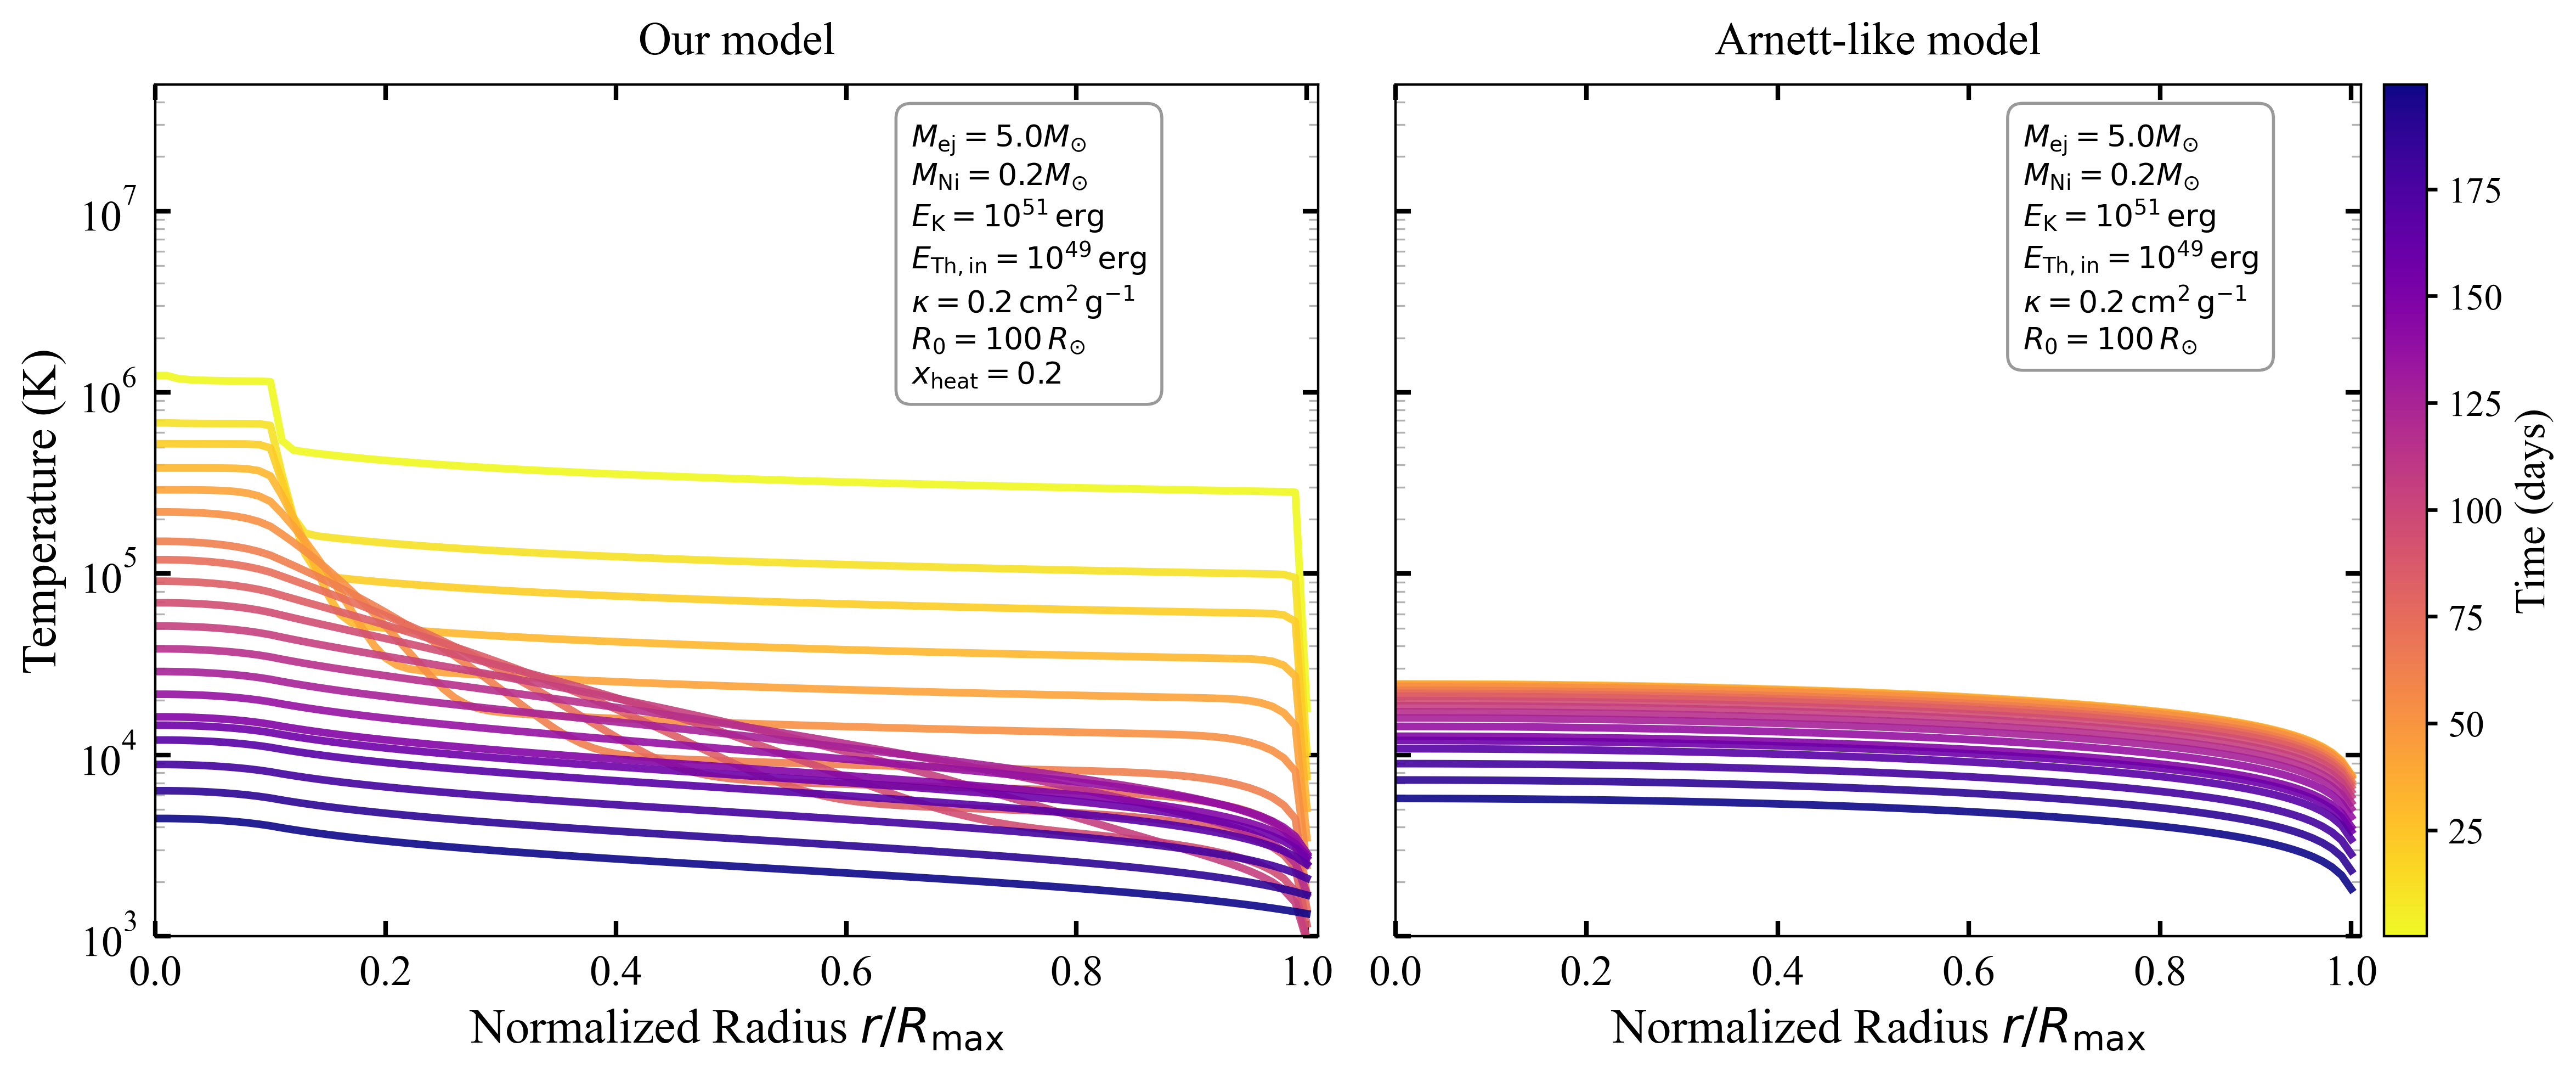

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter

# 假设已有下列全局变量或已在外部定义
# t_days, x_new, T_values           # 对应 "our model"
# t_days_Arnett, x_vals, T_vals_Arnett   # 对应 "Arnett-like model"

def plot_temperature_comparison(time_vals):

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, 
                                   figsize=(12, 5), dpi=400)

    colormap = plt.cm.plasma_r  
    colors = colormap(np.linspace(0, 1, len(time_vals)))
    
    # -----------------------------
    # 左图（our model）
    # -----------------------------
    time_indices_1 = [np.where(t_days >= t)[0][0] for t in sorted(time_vals)]
    for i, t in enumerate(sorted(time_vals)):
        idx = time_indices_1[i]
        ax1.plot(
            x_new, 
            T_values[:, idx], 
            lw=2.5, alpha=0.9, color=colors[i]
        )
    
    ax1.set_xlabel(r'Normalized Radius $r/R_{\rm max}$', fontsize=16)
    ax1.set_ylabel(r'Temperature (K)', fontsize=16)
    ax1.set_yscale('log')
    ax1.set_xlim(0, 1.01)
    ax1.set_ylim(1e3, 5e7)  
    ax1.set_title('Our model', fontsize=15, pad=10)

    params_text_1 = (
        r"$M_{\rm ej}=5.0M_{\odot}$" + "\n"
        + r"$M_{\rm Ni}=0.2M_{\odot}$" + "\n"
        + r"$E_{\rm K}=10^{51}\,\rm{erg}$" + "\n"
        + r"$E_{\rm Th,in}=10^{49}\,\rm{erg}$" + "\n"
        + r"$\kappa=0.2\,\rm{cm}^2\,\rm{g}^{-1}$" + "\n"
        + r"$R_{0}=100\,R_{\odot}$" + "\n"
        + r"$x_{\rm heat}=0.2$"
    )
    ax1.annotate(
        params_text_1,
        xy=(0.65, 0.65),
        xycoords='axes fraction',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8)
    )

    # -----------------------------
    # 右图（Arnett-like model）
    # -----------------------------
    time_indices_2 = [np.where(t_days_Arnett >= t)[0][0] for t in sorted(time_vals)]
    for i, t in enumerate(sorted(time_vals)):
        idx = time_indices_2[i]
        ax2.plot(
            x_vals, 
            T_vals_Arnett[:, idx], 
            lw=2.5, alpha=0.9, color=colors[i]
        )

    ax2.set_xlabel(r'Normalized Radius $r/R_{\rm max}$', fontsize=16)
    ax2.set_yscale('log')
    ax2.set_xlim(0, 1.01)
    ax2.set_ylim(1e3, 5e7)
    ax2.set_title('Arnett-like model', fontsize=15, pad=10)
    
    params_text_2 = (
        r"$M_{\rm ej}=5.0M_{\odot}$" + "\n"
        + r"$M_{\rm Ni}=0.2M_{\odot}$" + "\n"
        + r"$E_{\rm K}=10^{51}\,\rm{erg}$" + "\n"
        + r"$E_{\rm Th,in}=10^{49}\,\rm{erg}$" + "\n"
        + r"$\kappa=0.2\,\rm{cm}^2\,\rm{g}^{-1}$" + "\n"
        + r"$R_{0}=100\,R_{\odot}$"
    )
    ax2.annotate(
        params_text_2,
        xy=(0.65, 0.69),
        xycoords='axes fraction',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8)
    )

    # -----------------------------
    # 统一刻度风格
    # -----------------------------
    for axis in [ax1, ax2]:
        axis.tick_params(axis='both', which='major', labelsize=14, width=1.5)
        axis.tick_params(
            axis='both', which='both',
            direction='in',
            top=True,
            right=True,
            length=5,
            pad=6
        )
        axis.tick_params(
            which='minor',
            direction='in',
            length=3,
            color='0.7'
        )

    # -----------------------------
    # 只在右图 ax2 上放置颜色条
    # -----------------------------
    norm = mcolors.Normalize(vmin=min(time_vals), vmax=max(time_vals))
    sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    # 只传入 ax2, 就不会把 colorbar 关联到左图
    cbar = fig.colorbar(sm, ax=ax2, pad=0.02)  
    cbar.set_label(r"Time (days)", fontsize=14)
    cbar.ax.tick_params(labelsize=12, width=1.2)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    plt.tight_layout()
    plt.savefig("Temperature_comparison.pdf", bbox_inches='tight', dpi=1000)
    plt.show()

# ---------------------------------------
# 示例调用
# ---------------------------------------
time_vals = np.array([
    0.1, 0.5, 1.0, 2.0,
    3.52873502, 5.84341413,
    9.67641054, 12.45197085, 16.02366677,
    20.6198601, 26.5344154, 34.14548874, 43.93970561,
    56.5432741, 72.76202244, 80, 93.63292088, 120.49038191,
    155.05157798, 199.5262315
])
plot_temperature_comparison(time_vals)


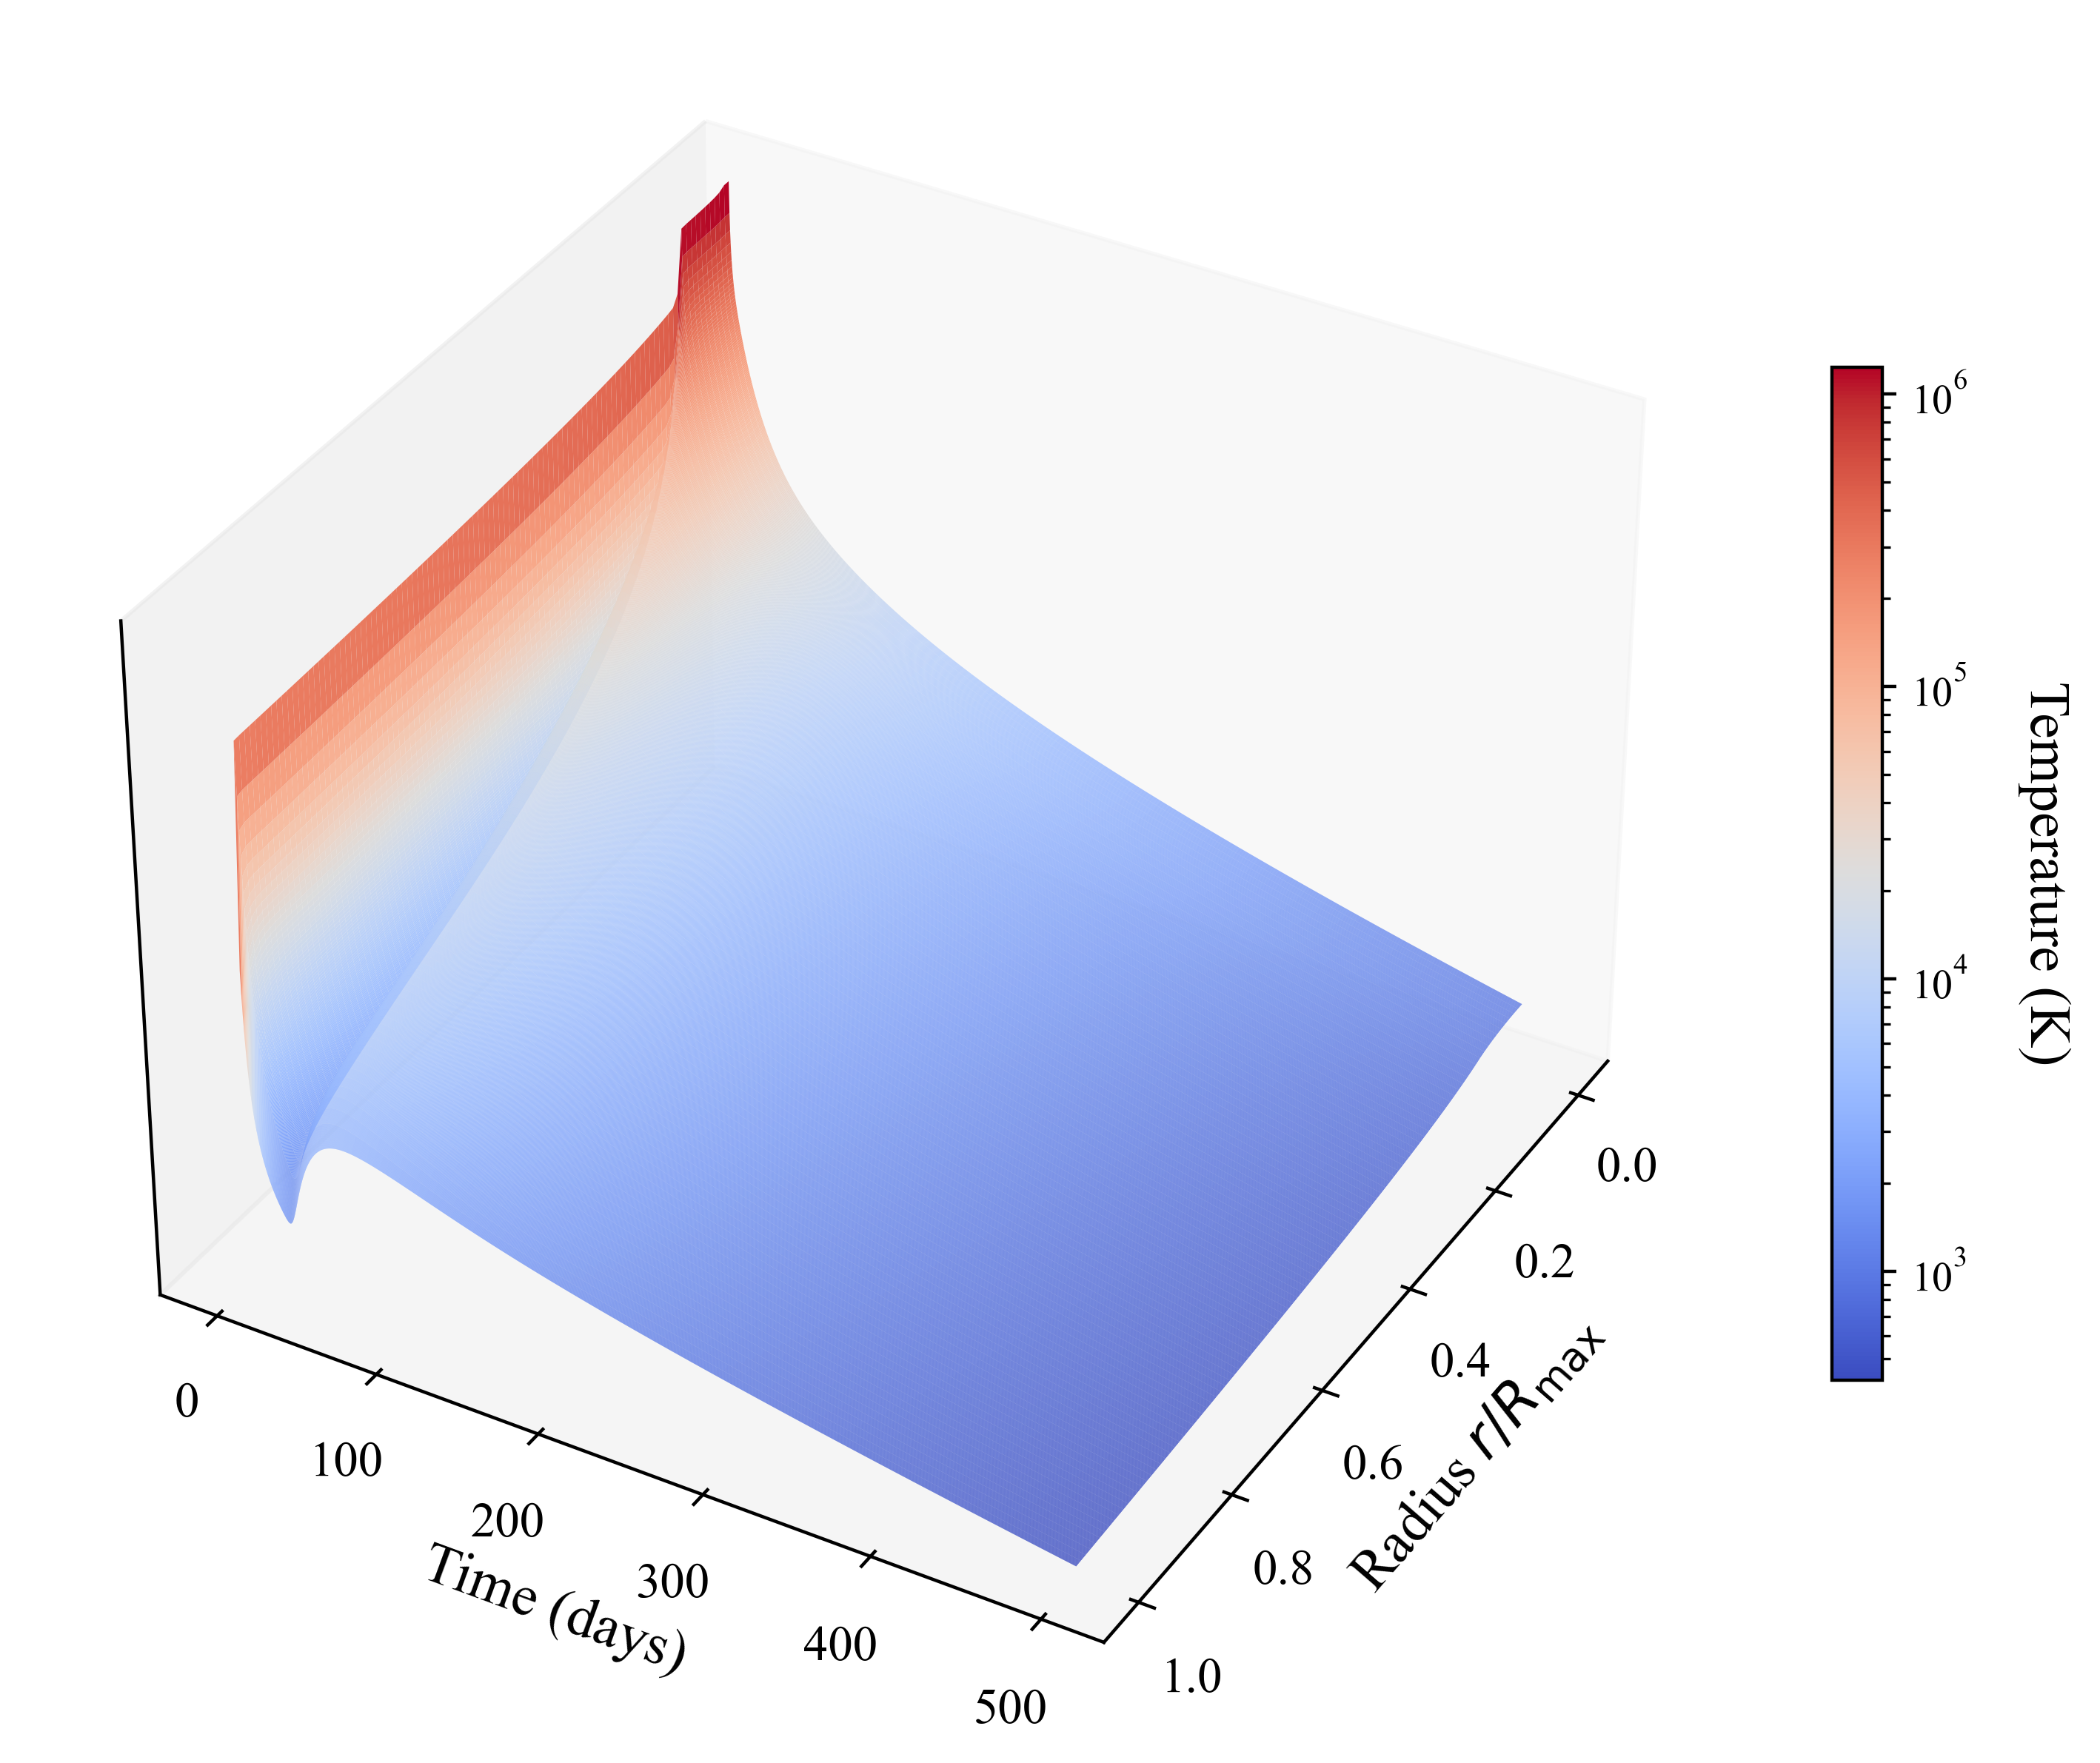

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, ticker
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable  # 注意这里改为从 cm 导入
from mpl_toolkits.mplot3d import Axes3D

# ========================
# 数据预处理
# ========================
yArray1 = t_days            # 时间(days)
xArray = x_new              # 归一化半径 r/R_max
xGrids, yGrids = np.meshgrid(xArray, yArray1)
zArray = T_values.T         # 原始温度数据（线性）

# 避免零值或负值导致LogNorm报错 (对极小温度进行裁剪)
zArray = np.clip(zArray, 1e-12, None)

# 三维表面使用的z：对数形态
zArray_log = np.log10(zArray)

# 对数标准化器（用于颜色映射）
norm = LogNorm(vmin=zArray.min(), vmax=zArray.max())
colors = cm.coolwarm(norm(zArray))   # 颜色数组

# ========================
# 创建三维图表
# ========================
fig = plt.figure(figsize=(8, 6), dpi=400)
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面，显式指定 facecolors，关闭 shade 保留原始颜色
surface = ax.plot_surface(
    xGrids,
    yGrids,
    zArray_log,
    facecolors=colors,
    rstride=1,
    cstride=1,
    linewidth=0,
    edgecolor='none',
    shade=False
)

# ========================
# 视角和坐标轴
# ========================
ax.view_init(elev=35, azim=30)
ax.set_xlabel(r'Radius $r/R_{\rm max}$', fontsize=14)
ax.set_ylabel(r'Time (days)', fontsize=14)
ax.set_zlabel('')
ax.set_zticks([])

# 可根据需要微调
num_ticks = 6
ax.set_xticks(np.linspace(0, xArray.max(), num_ticks))
ax.set_yticks(np.linspace(0, yArray1.max(), num_ticks))

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.grid(False)  # 去掉背景网格

# ========================
# 颜色条匹配
# ========================
# 通过 ScalarMappable 生成颜色条
mappable = ScalarMappable(norm=norm, cmap=cm.coolwarm)
mappable.set_array([])  # 仅用于给 colorbar 正确映射

cbar = fig.colorbar(mappable, ax=ax, shrink=0.6, aspect=20, pad=0.05)
cbar.set_label('Temperature (K)', rotation=270, labelpad=25, fontsize=14)

# 对数刻度
cbar.ax.yaxis.set_major_formatter(ticker.LogFormatterSciNotation())
cbar.ax.yaxis.set_minor_formatter(ticker.NullFormatter())
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('Temperature_3D_log.pdf', bbox_inches='tight', dpi=600)
plt.show()



In [10]:
# import matplotlib.animation as animation
# from matplotlib import rcParams

# def create_temperature_animation(time_vals, x_new, T_values, t_days):
#     # 排序时间并获取对应索引
#     sorted_time_vals = sorted(time_vals)
#     time_indices = [np.where(t_days >= t)[0][0] for t in sorted_time_vals]
    
#     # 初始化图形和颜色
#     fig, ax = plt.subplots(figsize=(8, 6), dpi=400)
#     colormap = plt.cm.plasma
#     colors = colormap(np.linspace(0, 1, len(sorted_time_vals)))
    
#     # 坐标轴设置
#     ax.set_title('Temperature profiles evolution over time in our model', fontsize=16, pad=12)
#     ax.set_xlabel(r'Radial coordinate $r/R_{\rm max}$', fontsize=18)
#     ax.set_ylabel(r'Temperature (K)', fontsize=18)
#     ax.set_yscale('log')
#     ax.set_xlim(0, 1.01)
#     ax.set_ylim(1e3, 5e6)
#     ax.tick_params(axis='both', which='major', labelsize=14, width=1.5)
    
#     ##颜色条设置
#     norm = mcolors.Normalize(vmin=min(time_vals), vmax=max(time_vals))
#     sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
#     cbar = plt.colorbar(sm, ax=ax, pad=0.02)
#     cbar.set_label(r"Time (days)", fontsize=16)
#     cbar.ax.tick_params(labelsize=12, width=1.2)
    
    
#     # 动态元素初始化
#     time_text = ax.text(0.1, 0.9, '', transform=ax.transAxes, fontsize=12)
#     lines = []

#     def init():
#         time_text.set_text('')
#         return [time_text]

#     def animate(i):
#         # 绘制当前时间曲线
#         idx = time_indices[i]
#         line, = ax.plot(x_new, T_values[:, idx], color=colors[i], lw=2.5, alpha=0.9)
#         lines.append(line)
#         # 更新当前时间文本
#         time_text.set_text(f'Time: {sorted_time_vals[i]:.1f} days')
#         return lines + [time_text]

#     # 创建动画
#     anim = animation.FuncAnimation(
#         fig, animate, frames=len(sorted_time_vals),
#         init_func=init, interval=200, blit=False
#     )
#     # plt.show()
#     plt.close(fig)
#     return anim

# # 使用示例

# time_vals = np.array([ 0.5, 1 ,   2.,
#          3.52873502,    5.84341413,
#           9.67641054,  12.45197085,  16.02366677,
#         20.6198601 ,  26.5344154 ,  34.14548874,  43.93970561,
#         56.5432741 ,  72.76202244,80,  93.63292088, 120.49038191,
#        155.05157798, 199.5262315 ])
# anim = create_temperature_animation(time_vals, x_new, T_values, t_days)
# anim.save('Temperature_evolution.gif',  writer='pillow', dpi=150)
# # anim.save('Temperature_evolution.mp4',  writer='pillow', dpi=500)


In [11]:
# def create_temperature_animation_Arnett(time_vals, x_new, T_values, t_days):
#     # 排序时间并获取对应索引
#     sorted_time_vals = sorted(time_vals)
#     time_indices = [np.where(t_days >= t)[0][0] for t in sorted_time_vals]
    
#     # 初始化图形和颜色
#     fig, ax = plt.subplots(figsize=(8, 6), dpi=400)
#     colormap = plt.cm.plasma
#     colors = colormap(np.linspace(0, 1, len(sorted_time_vals)))
    
#     # 坐标轴设置
#     ax.set_title('Temperature profiles evolution over time in Arnett-like model', fontsize=16, pad=12)
#     ax.set_xlabel(r'Radial coordinate $r/R_{\rm max}$', fontsize=18)
#     ax.set_ylabel(r'Temperature (K)', fontsize=18)
#     ax.set_yscale('log')
#     ax.set_xlim(0, 1.01)
#     ax.set_ylim(1e3, 1e5)
#     ax.tick_params(axis='both', which='major', labelsize=14, width=1.5)
    
#     ##颜色条设置
#     norm = mcolors.Normalize(vmin=min(time_vals), vmax=max(time_vals))
#     sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
#     cbar = plt.colorbar(sm, ax=ax, pad=0.02)
#     cbar.set_label(r"Time (days)", fontsize=16)
#     cbar.ax.tick_params(labelsize=12, width=1.2)
    
    
#     # 动态元素初始化
#     time_text = ax.text(0.1, 0.9, '', transform=ax.transAxes, fontsize=12)
#     lines = []

#     def init():
#         time_text.set_text('')
#         return [time_text]

#     def animate(i):
#         # 绘制当前时间曲线
#         idx = time_indices[i]
#         line, = ax.plot(x_new, T_values[:, idx], color=colors[i], lw=2.5, alpha=0.9)
#         lines.append(line)
#         # 更新当前时间文本
#         time_text.set_text(f'Time: {sorted_time_vals[i]:.1f} days')
#         return lines + [time_text]

#     # 创建动画
#     anim = animation.FuncAnimation(
#         fig, animate, frames=len(sorted_time_vals),
#         init_func=init, interval=200, blit=False
#     )
#     # plt.show()
#     plt.close(fig)
#     return anim

# # 使用示例

# time_vals = np.linspace(0.1, 200, 30)
# anim = create_temperature_animation_Arnett(time_vals, x_vals, T_vals_Arnett, t_days_Arnett)
# anim.save('Temperature_evolution_Arnett.gif',  writer='pillow', dpi=150)
# # # anim.save('Temperature_evolution_Arnett.mp4',  writer='pillow', dpi=500)


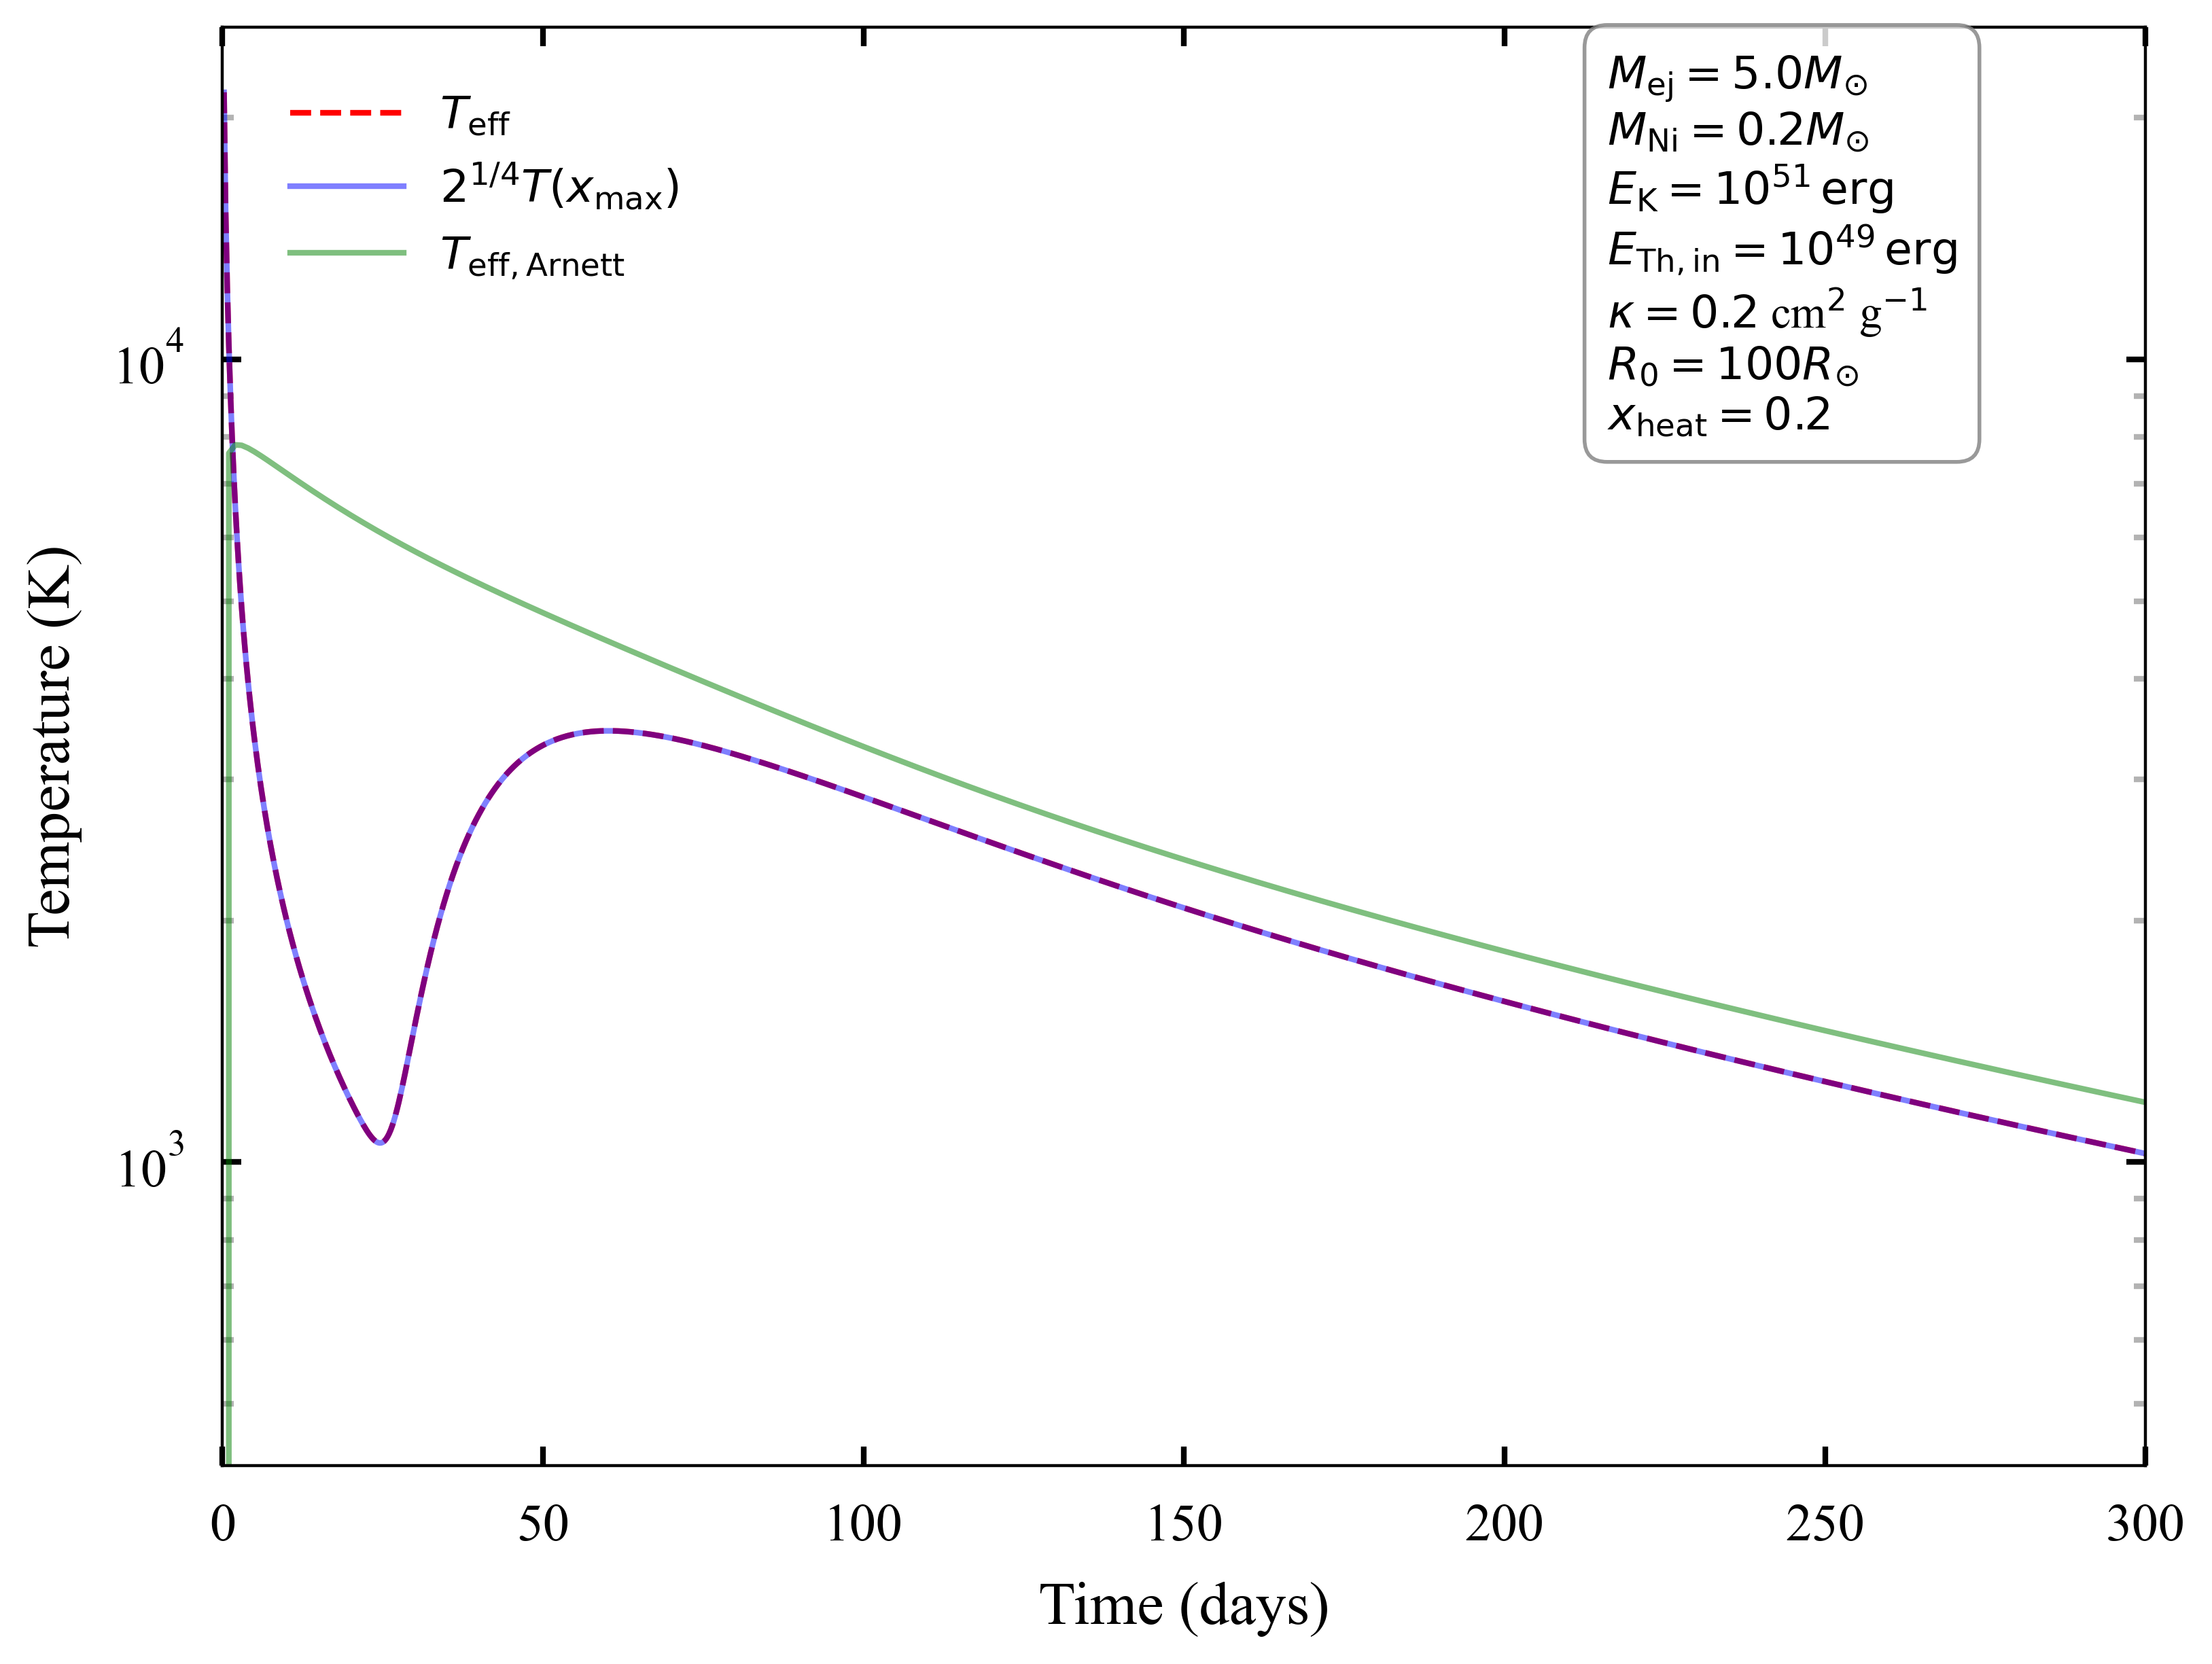

In [4]:
plt.figure(figsize=(8, 6),dpi=400)
plt.plot(t_days,T_eff_values,'r--', label=r'$T_{\rm{eff}}$')
plt.plot(t_days, 2**(0.25)*T_values[-1,:],'b',alpha=0.5, label=r'$2^{1/4}T(x_{\rm{max}})$')
plt.plot(t_days_Arnett,T_eff_Arnett,'g',alpha=0.5,label=r'$T_{\rm{eff,Arnett}}$')
# plt.plot(t_days_Arnett, T_vals_Arnett[-1,:],'y--',alpha=0.5,label=r'$T(x_{\rm{max},Arnett})$')
# plt.plot(t_days_onezone,T_vals_onezone[-1,:],'y--',alpha=0.5,label=r'$T_{x_{\rm{max},onezone}}$')
# plt.plot(t_days_onezone,T_eff_onezone,'k',alpha=0.5,label=r'$T_{\rm{eff,Onezone}}$')
    # 刻度设置（核心修改部分）
plt.tick_params(
    axis='both', 
    which='both',
    direction='in',        # 刻度朝向图形内部
    top=True,               # 开启上侧刻度
    right=True,             # 开启右侧刻度
    labelsize=14,
    width=1.5,
    length=5,             # 主刻度长度
    pad=10                 # 标签与刻度间距
)
plt.tick_params(
    which='minor', 
    direction='in',         # 次刻度同样朝内
    length=3,               # 次刻度稍短
    color='0.7'             # 灰色次刻度
)
# 增强图例可读性
plt.legend(fontsize=12, 
           frameon=False,  # Remove the border
           loc='upper left',
           handlelength=2.5,
           borderpad=1.0,
           shadow=False)  # Remove the shadow


# 参数框设置
params_text = (
    r"$M_{\rm ej}=5.0M_{\odot}$" + "\n"
    + r"$M_{\rm Ni}=0.2M_{\odot}$" + "\n"
    + r"$E_{\rm K}=10^{51} \, \rm{erg}$" + "\n"
    + r"$E_{\rm Th,in}=10^{49} \, \rm{erg}$"  +"\n"
    + r"$\kappa=0.2$ cm$^{2}$ g$^{-1}$" + "\n"
    + r"$R_{\rm 0}=100R_{\odot}$" + "\n"
    + r"$x_{\rm heat}=0.2$"
)
plt.annotate(params_text, 
            xy=(0.72, 0.72),  # 调整到右上方
            xycoords='axes fraction',
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

# 网格线优化（主次网格）
# plt.grid(True, which='major', ls='-', alpha=0.5, lw=1.2)
# plt.grid(True, which='minor', ls=':', alpha=0.3, lw=0.8)
plt.tight_layout()

# 保存图像，提升分辨率

plt.xlim(0, 3e2)
plt.xlabel('Time (days)', fontsize=16, labelpad=8)
plt.ylabel('Temperature (K)', fontsize=16, labelpad=8)
plt.yscale('log')
plt.savefig("T_eff.pdf",bbox_inches='tight',  dpi=1000)  # 高分辨率保存
plt.show()

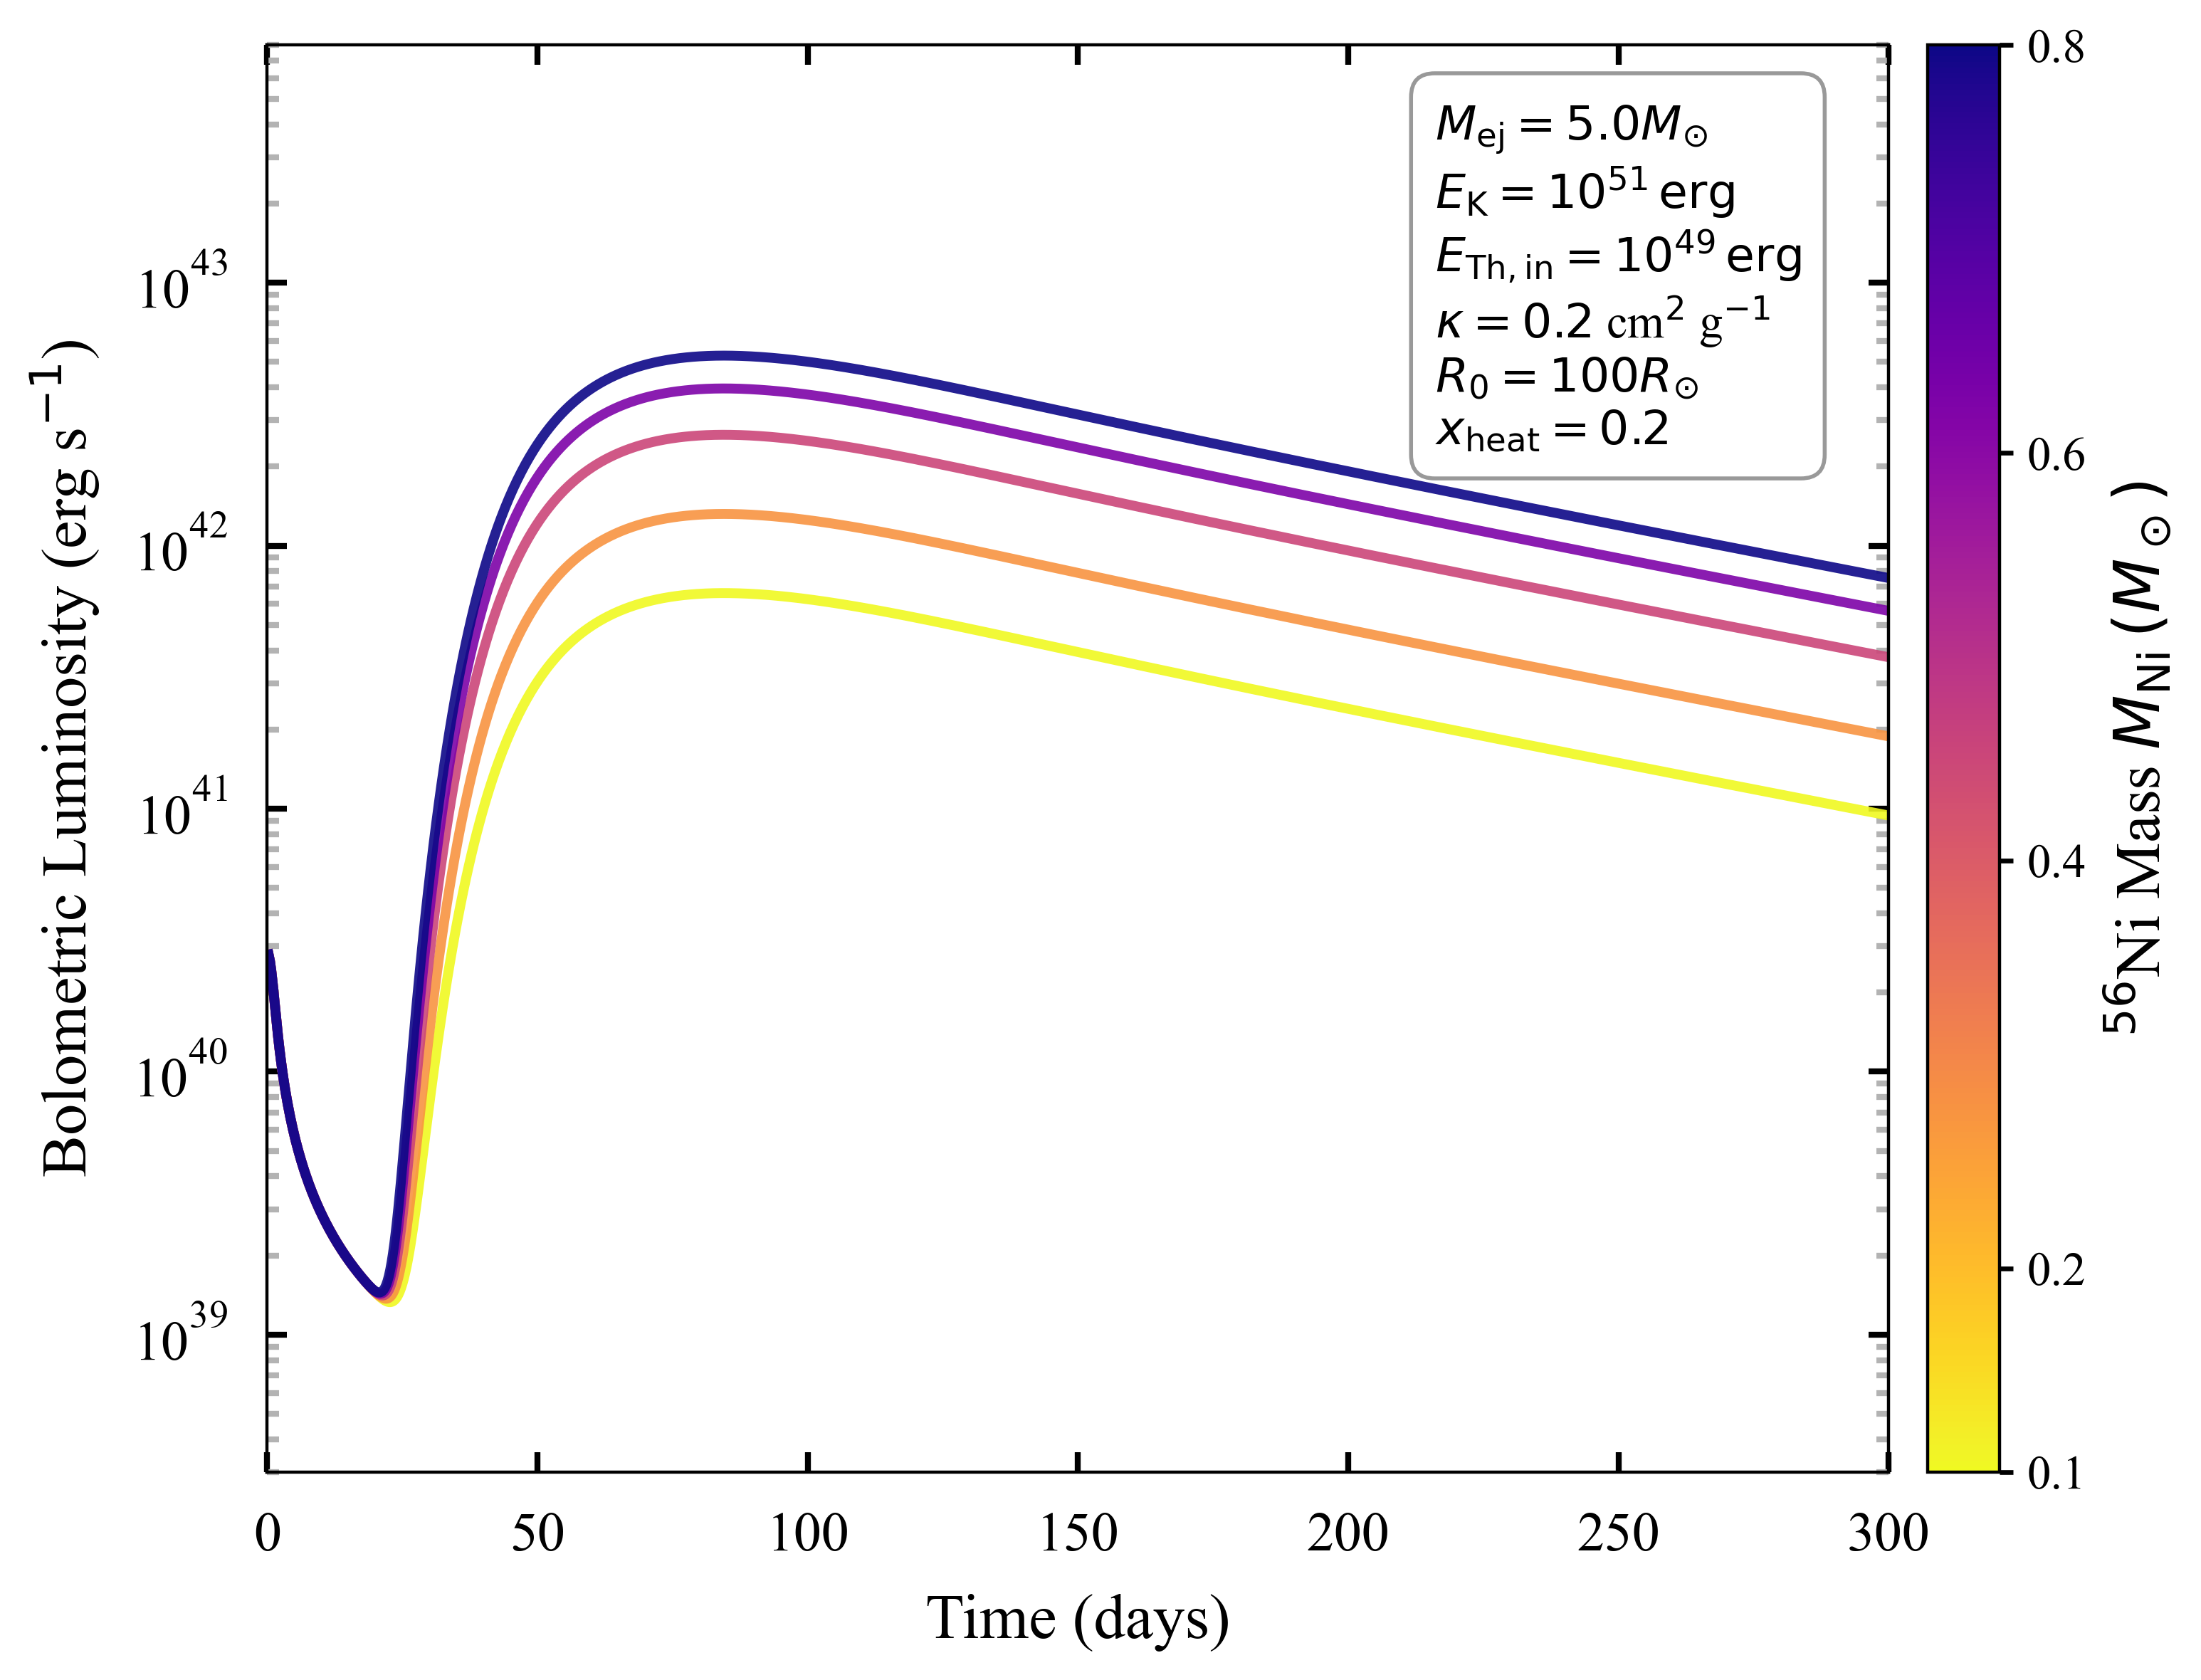

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.ticker import FormatStrFormatter  # 添加缺失的导入

def plot_lc_different_M_Ni(M_Ni_values):
    plt.figure(figsize=(8, 6), dpi=400)  # 提高分辨率，增加清晰度
    colormap = plt.cm.plasma_r  # 使用反转的plasma色图  
    colors = colormap(np.linspace(0, 1, len(M_Ni_values)))
    
    # 绘制曲线
    for i, M_Ni in enumerate(M_Ni_values):
        sn = SupernovaLightCurve()
        t, L_bol, *_, = sn.calculate_light_curve(M_Ni=M_Ni)
        plt.plot(t, L_bol, lw=2.5, alpha=0.9, color=colors[i])

    # 坐标轴设置
    plt.yscale('log')
    plt.xlim(0, 3e2)
    plt.ylim(3e38, 8e43)
    plt.xlabel("Time (days)", fontsize=16, labelpad=8)
    plt.ylabel(r"Bolometric Luminosity (erg s$^{-1}$)", fontsize=16, labelpad=8)
    plt.tick_params(axis='both', which='major', labelsize=14, width=1.5)
    
    # 颜色条设置 (修正参数顺序)
    M_Ni_solar = np.array(M_Ni_values) / M_sun
    norm = mcolors.Normalize(vmin=min(M_Ni_solar), vmax=max(M_Ni_solar))
    sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)  # 显式指定ax参数
    cbar.set_label(r"$^{56}$Ni Mass $M_{\rm Ni}\,(M_\odot)$", fontsize=16)
    cbar.set_ticks(M_Ni_solar)
    cbar.ax.tick_params(labelsize=12, width=1.2)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # 正确使用格式化

    # 刻度设置（核心修改部分）
    plt.tick_params(
        axis='both', 
        which='both',
        direction='in',        # 刻度朝向图形内部
        top=True,               # 开启上侧刻度
        right=True,             # 开启右侧刻度
        labelsize=14,
        width=1.5,
        length=5,             # 主刻度长度
        pad=10                 # 标签与刻度间距
    )
    plt.tick_params(
        which='minor', 
        direction='in',         # 次刻度同样朝内
        length=3,               # 次刻度稍短
        color='0.7'             # 灰色次刻度
    )

    # 参数框设置
    params_text = (
        r"$M_{\rm ej}=5.0M_{\odot}$" + "\n"
        + r"$E_{\rm K}=10^{51} \, \rm{erg}$" + "\n"
        + r"$E_{\rm Th,in}=10^{49} \, \rm{erg}$"  +"\n"
        + r"$\kappa=0.2$ cm$^{2}$ g$^{-1}$" + "\n"
        + r"$R_{\rm 0}=100R_{\odot}$" + "\n"
        + r"$x_{\rm heat}=0.2$"
    )
    plt.annotate(params_text, 
                xy=(0.72, 0.72),  # 调整到右上方
                xycoords='axes fraction',
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

    # # 网格线优化（主次网格）
    # plt.grid(True, which='major', ls='-', alpha=0.5, lw=1.2)
    # plt.grid(True, which='minor', ls=':', alpha=0.3, lw=0.8)
    
    plt.tight_layout()
    
    # 保存图像，提升分辨率
    plt.savefig("lc_different_M_Ni.pdf",bbox_inches='tight',  dpi=1000)  # 高分辨率保存
    plt.show()

# 使用示例
M_Ni_values = [0.1*M_sun, 0.2*M_sun, 0.4*M_sun, 0.6*M_sun, 0.8*M_sun]
plot_lc_different_M_Ni(M_Ni_values)


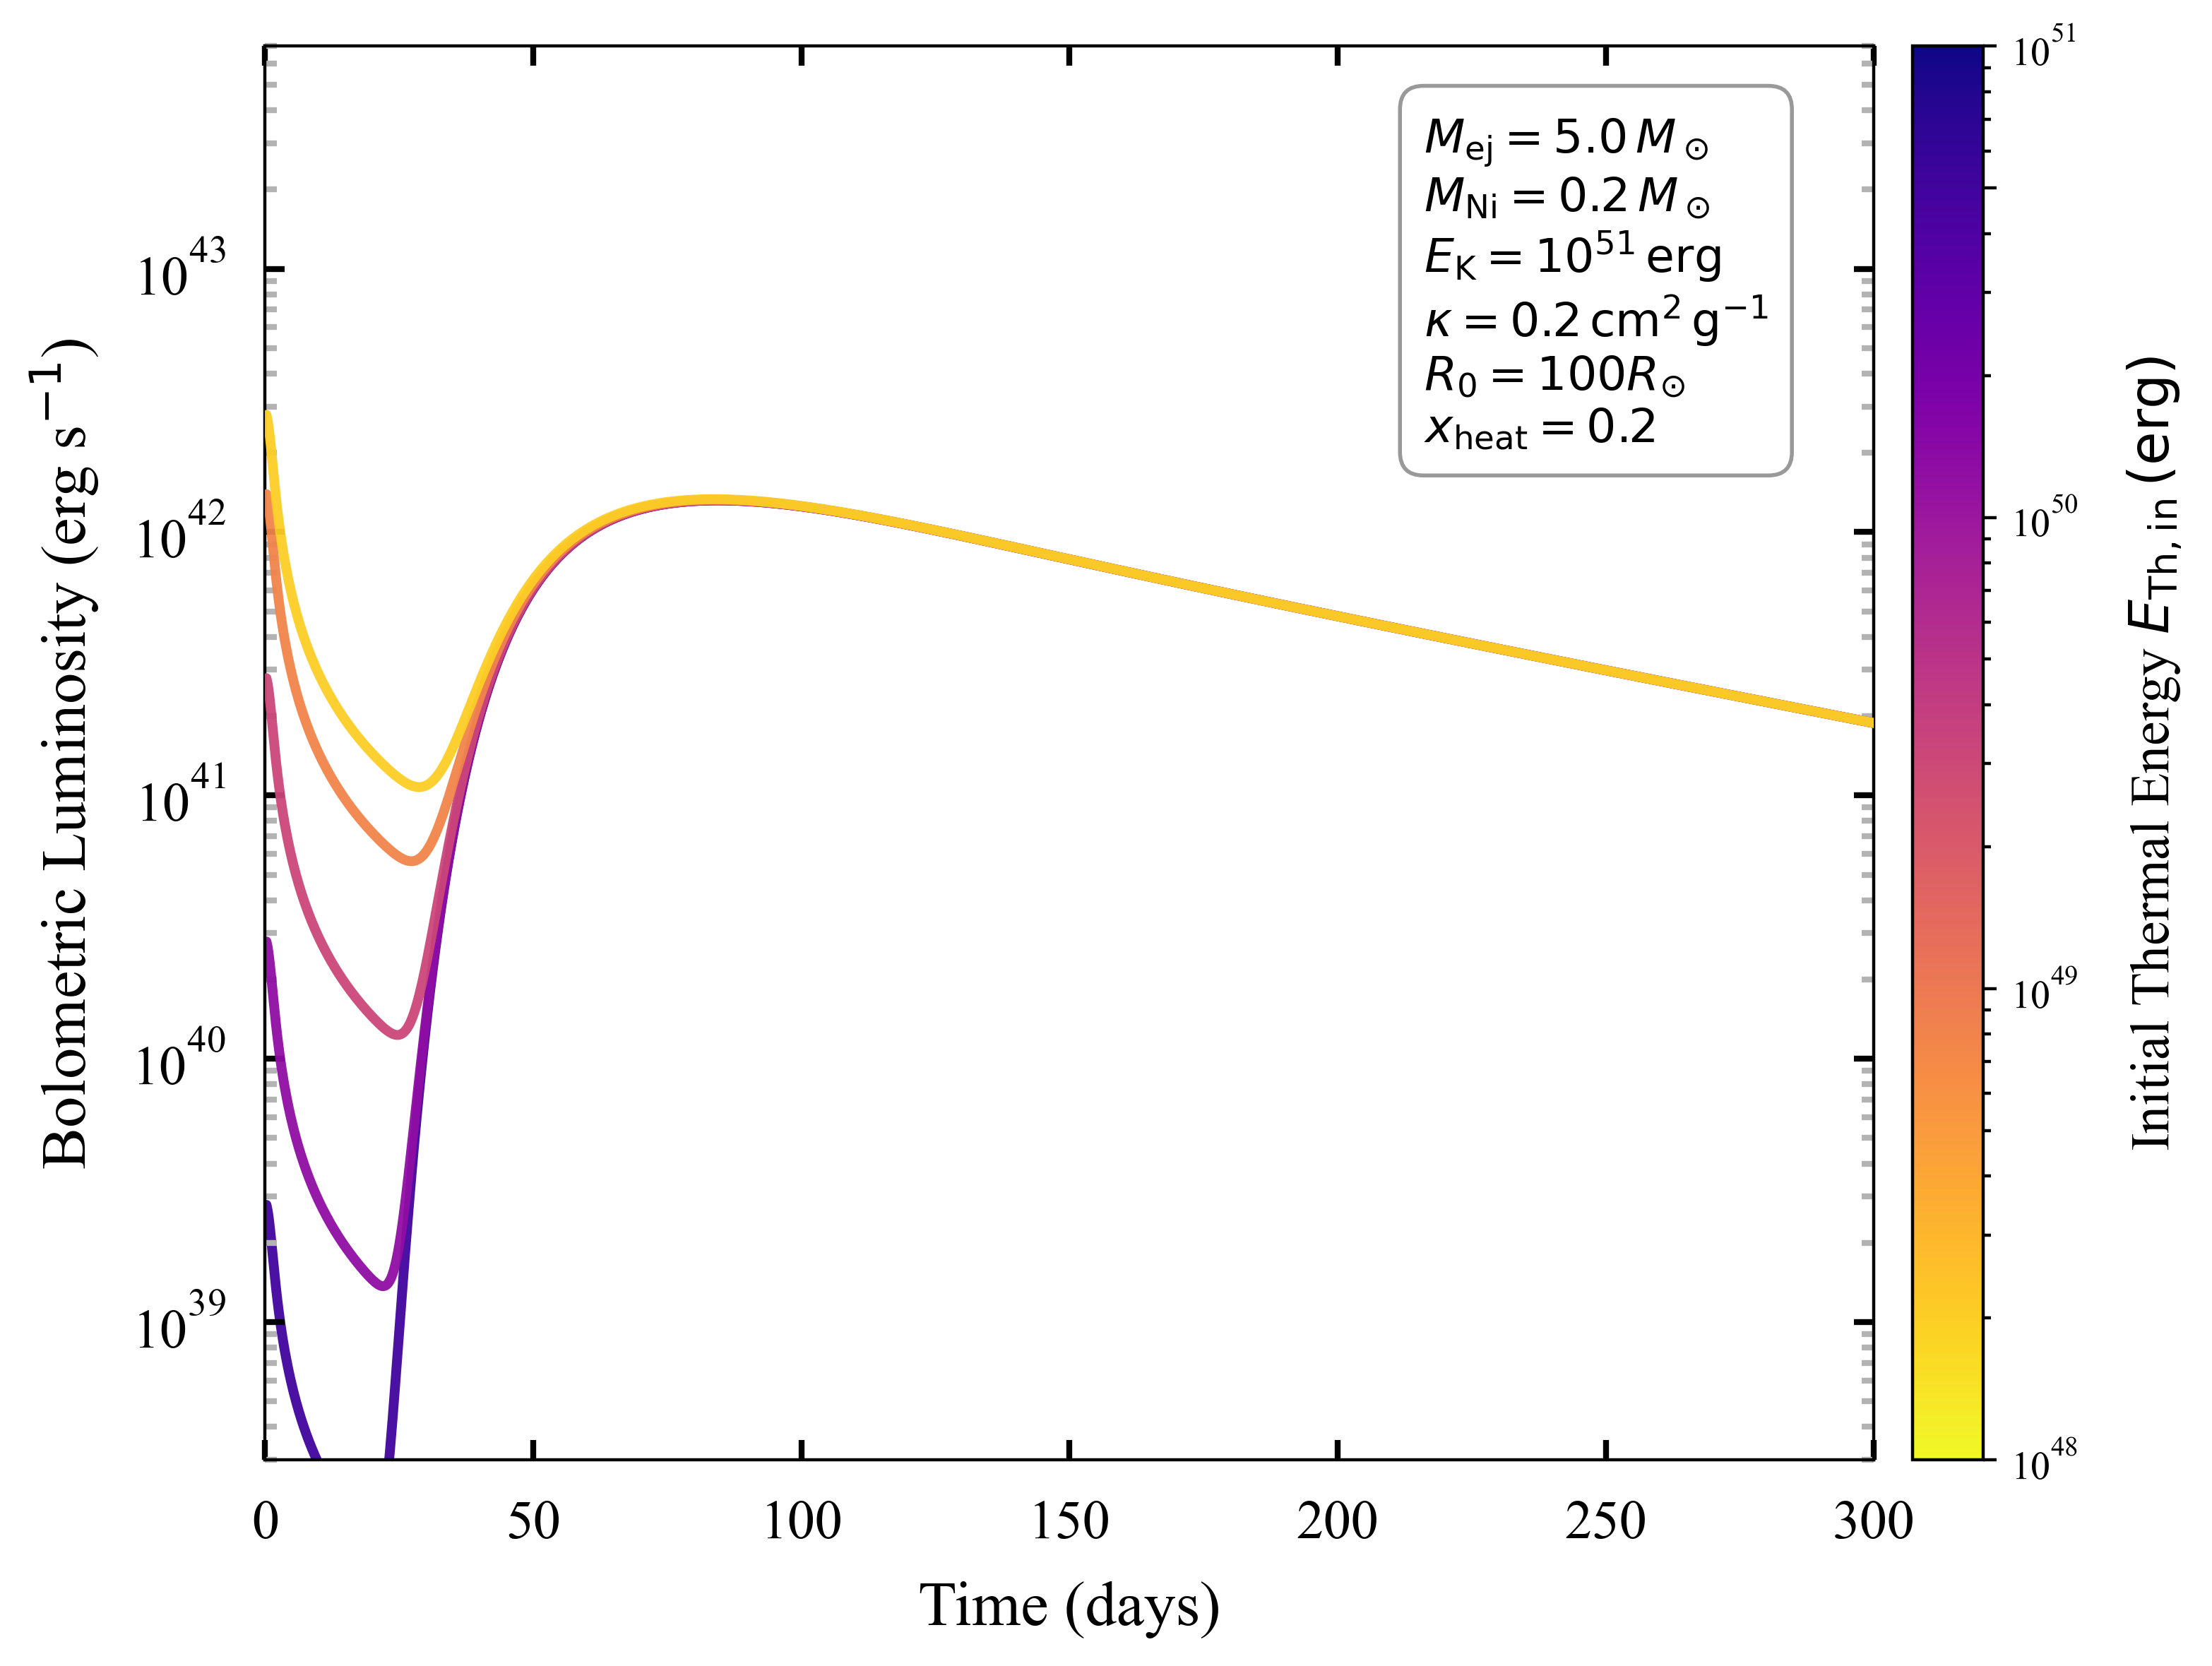

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.ticker import FormatStrFormatter, LogFormatterSciNotation
from matplotlib.colors import LogNorm  # 添加LogNorm导入

def plot_lc_different_E_Th(E_Th_in_values):
    plt.figure(figsize=(8, 6), dpi=400)
    colormap = plt.cm.plasma_r  # 反向色阶使高值更醒目
    colors = colormap(np.linspace(0.1, 0.9, len(E_Th_in_values)))  # 截取中间色段
    
    # 绘制曲线（添加zorder控制绘制顺序）
    for i, E_Th_in in enumerate(sorted(E_Th_in_values, reverse=True)):
        sn = SupernovaLightCurve()
        t, L_bol, *_,  = sn.calculate_light_curve(E_Th_in=E_Th_in)
        plt.plot(t, L_bol, lw=2.5, alpha=0.95, color=colors[i], 
                zorder=len(E_Th_in_values)-i,  # 保证高值曲线在上层
                solid_capstyle='round')

    # 坐标轴设置（优化科学记数法显示）
    plt.yscale('log')
    # plt.xscale('log')  # 添加对数时间坐标
    plt.xlim(0, 3e2)
    plt.ylim(3e38, 7e43)
    plt.xlabel("Time (days)", fontsize=16, labelpad=8)
    plt.ylabel(r"Bolometric Luminosity (erg s$^{-1}$)", fontsize=16, labelpad=8)
    plt.tick_params(axis='both', which='both', labelsize=12, width=1.2)
    
    # 颜色条设置（对数归一化）
    norm = LogNorm(vmin=min(E_Th_in_values), vmax=max(E_Th_in_values))
    sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
    cbar.set_label(r"Initial Thermal Energy $E_{\rm Th,in}\,(\rm{erg})$", fontsize=14, labelpad=12)
    cbar.set_ticks(E_Th_in_values)
    cbar.ax.tick_params(labelsize=10, width=0.8, which='both')
    cbar.ax.yaxis.set_major_formatter(LogFormatterSciNotation())  # 科学记数法格式化
      # 刻度设置（核心修改部分）

    # 参数框设置
    params_text = (
        r"$M_{\rm ej}=5.0\,M_\odot$" + "\n"
        + r"$M_{\rm Ni}=0.2\,M_\odot$" + "\n"
        + r"$E_{\rm K}=10^{51}\,{\rm erg}$" + "\n"
        + r"$\kappa=0.2\,{\rm cm^2\,g^{-1}}$" + "\n"
         + r"$R_{\rm 0}=100R_{\odot}$"+ "\n"
        + r"$x_{\rm heat}=0.2$"
    )


    plt.annotate(params_text, 
                xy=(0.72, 0.72),  # 调整到右上方
                xycoords='axes fraction',
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))
    
    plt.tick_params(
        axis='both', 
        which='both',
        direction='in',        # 刻度朝向图形内部
        top=True,               # 开启上侧刻度
        right=True,             # 开启右侧刻度
        labelsize=14,
        width=1.5,
        length=5,             # 主刻度长度
        pad=10                 # 标签与刻度间距
    )
    plt.tick_params(
        which='minor', 
        direction='in',         # 次刻度同样朝内
        length=3,               # 次刻度稍短
        color='0.7'             # 灰色次刻度
    )


    # # 网格线优化（主次网格）
    # plt.grid(True, which='major', ls='-', alpha=0.5, lw=1.2)
    # plt.grid(True, which='minor', ls=':', alpha=0.3, lw=0.8)
    
    plt.tight_layout()
    # 参数框设置（优化排版和符号一致性）


    
    # 输出设置（优化PDF参数）
    plt.tight_layout()
    
    plt.savefig("lc_different_E_Th_in.pdf", 
               dpi=600, 
               bbox_inches='tight', 
               metadata={'CreationDate': None})  # 避免PDF时间戳
    plt.show()

# 使用示例
E_Th_in_values = [1e48, 1e49, 1e50, 5e50, 1e51]
plot_lc_different_E_Th(E_Th_in_values)

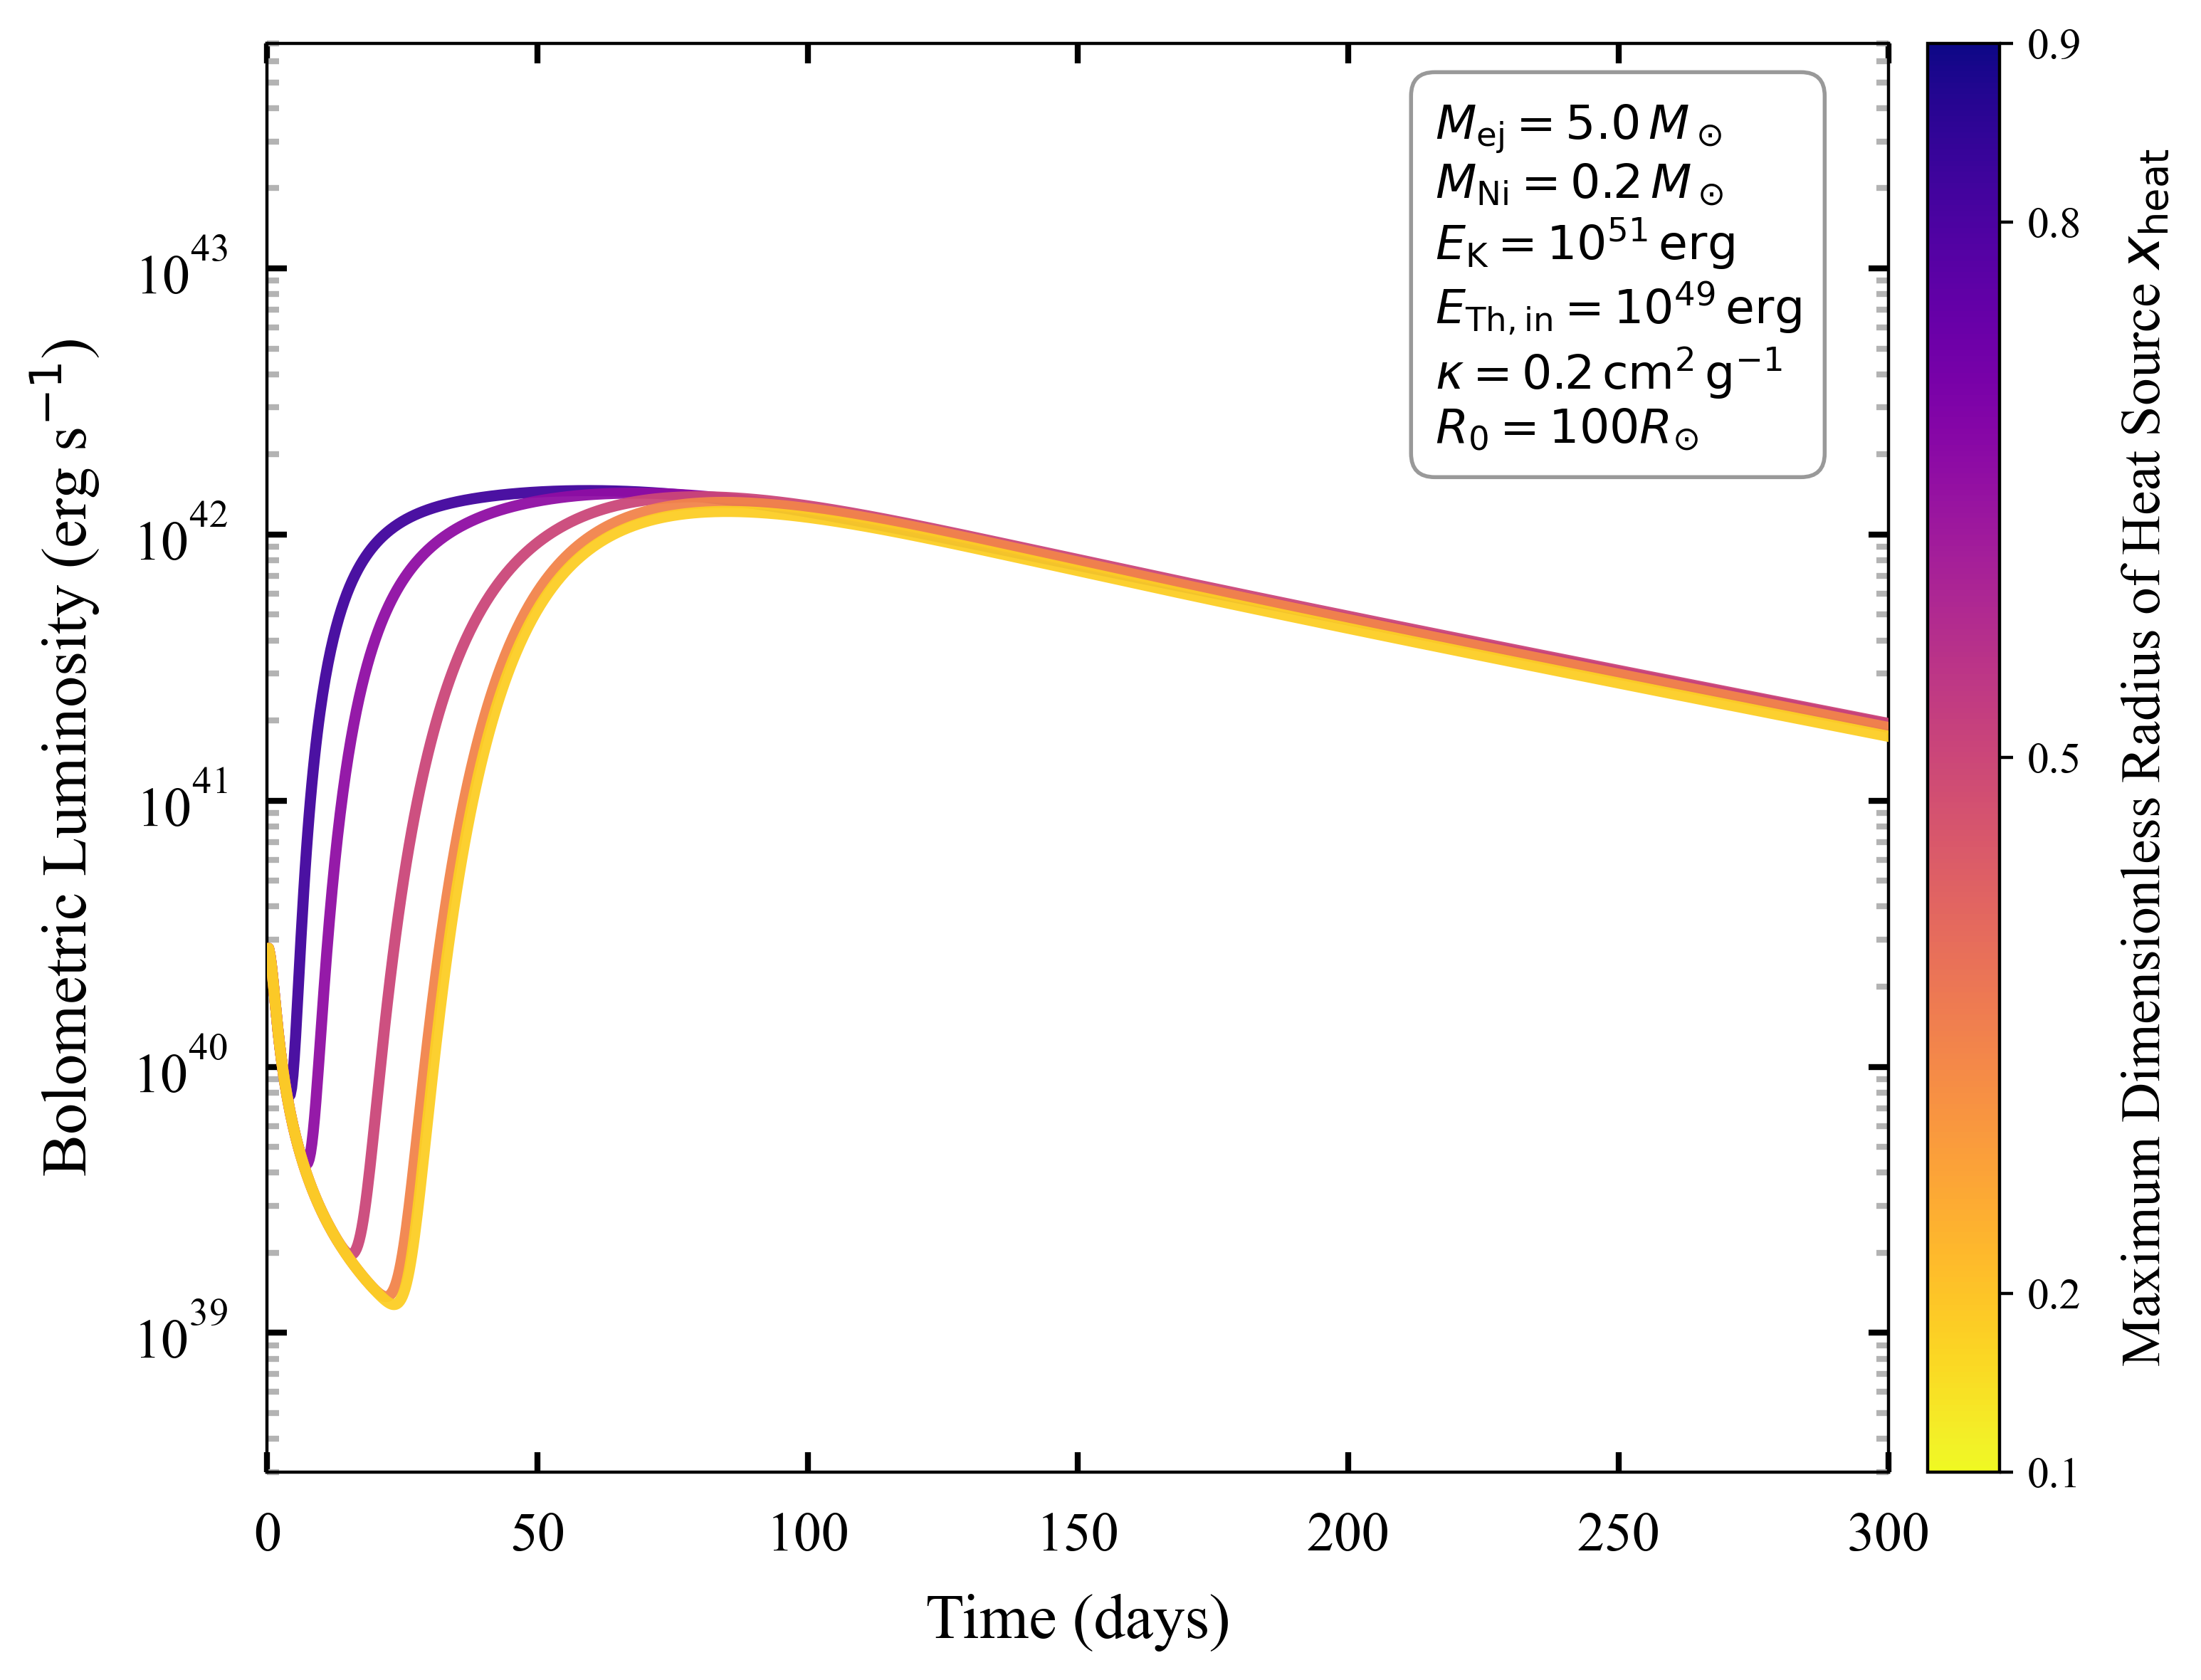

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.ticker import LogFormatterSciNotation
t_s = np.linspace(0,300,1000)*day
def plot_lc_different_x_s(x_s_values):
    plt.figure(figsize=(8, 6), dpi=400)
    cmap = plt.cm.plasma_r  # 使用反向色阶增强对比度
    colors = cmap(np.linspace(0.1, 0.9, len(x_s_values)))  # 截取中间色段
    
    # 绘制基准镍衰变曲线
    # plt.plot(t_s/day, L_Ni56(t_s), 'k--', lw=2.5, 
    #         label=r'$^{56}$Ni heating rate', zorder=1, alpha=0.7)
    
    # 按x_s值倒序绘制（保证高值在上层）
    for i, x_s in enumerate(sorted(x_s_values)):
        sn = SupernovaLightCurve()
        t, L_bol, *_ = sn.calculate_light_curve(x_s=x_s)
        plt.plot(t, L_bol, lw=2.8, 
                color=colors[i], 
                alpha=0.95,
                solid_capstyle='round',
                zorder=len(x_s_values)-i)

    # 坐标轴设置（对数坐标优化）
    # plt.xscale('log')  # 启用对数时间轴
    
    plt.yscale('log')
    plt.xlim(0, 3e2)  # 扩展下限以更好展示对数刻度
    plt.ylim(3e38, 7e43)
    plt.xlabel("Time (days)", fontsize=16, labelpad=8)
    plt.ylabel(r"Bolometric Luminosity (erg s$^{-1}$)", fontsize=16, labelpad=8)
    plt.tick_params(axis='both', which='both', labelsize=12, width=1.2)
    
    # 颜色条设置（科学记数法格式化）
    norm = mcolors.Normalize(vmin=min(x_s_values), vmax=max(x_s_values))
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
    cbar.set_label(r"Maximum Dimensionless Radius of Heat Source $x_{\rm heat}$", fontsize=14, labelpad=10)
    cbar.set_ticks(x_s_values)
    cbar.ax.tick_params(labelsize=11, width=0.8)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # 保留1位小数
    # 刻度设置（核心修改部分）

    # 参数框设置（优化排版和间距）
    params_text = (
        r"$M_{\rm ej}=5.0\,M_\odot$" + "\n"
        + r"$M_{\rm Ni}=0.2\,M_\odot$" + "\n"
        + r"$E_{\rm K}=10^{51}\,{\rm erg}$" + "\n"
        + r"$E_{\rm Th,in}=10^{49}\,{\rm erg}$" + "\n"
        + r"$\kappa=0.2\,{\rm cm^2\,g^{-1}}$" + "\n"
         + r"$R_{\rm 0}=100R_{\odot}$"
         
    )
    plt.annotate(params_text, 
            xy=(0.72, 0.72),  # 调整到右上方
            xycoords='axes fraction',
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

    plt.tick_params(
        axis='both', 
        which='both',
        direction='in',        # 刻度朝向图形内部
        top=True,               # 开启上侧刻度
        right=True,             # 开启右侧刻度
        labelsize=14,
        width=1.5,
        length=5,             # 主刻度长度
        pad=10                 # 标签与刻度间距
    )
    plt.tick_params(
        which='minor', 
        direction='in',         # 次刻度同样朝内
        length=3,               # 次刻度稍短
        color='0.7'             # 灰色次刻度
    )


    # # 网格线优化（主次网格）
    # plt.grid(True, which='major', ls='-', alpha=0.5, lw=1.2)
    # plt.grid(True, which='minor', ls=':', alpha=0.3, lw=0.8)
    
    plt.tight_layout()
    # 参数框设置（优化排版和符号一致性）
    plt.savefig("lc_different_x_s.pdf", 
               dpi=1000, 
               bbox_inches='tight', 
               metadata={'CreationDate': None})
    plt.show()

# 使用示例
x_s_values = [0.1, 0.2, 0.5, 0.8, 0.9]
plot_lc_different_x_s(x_s_values)

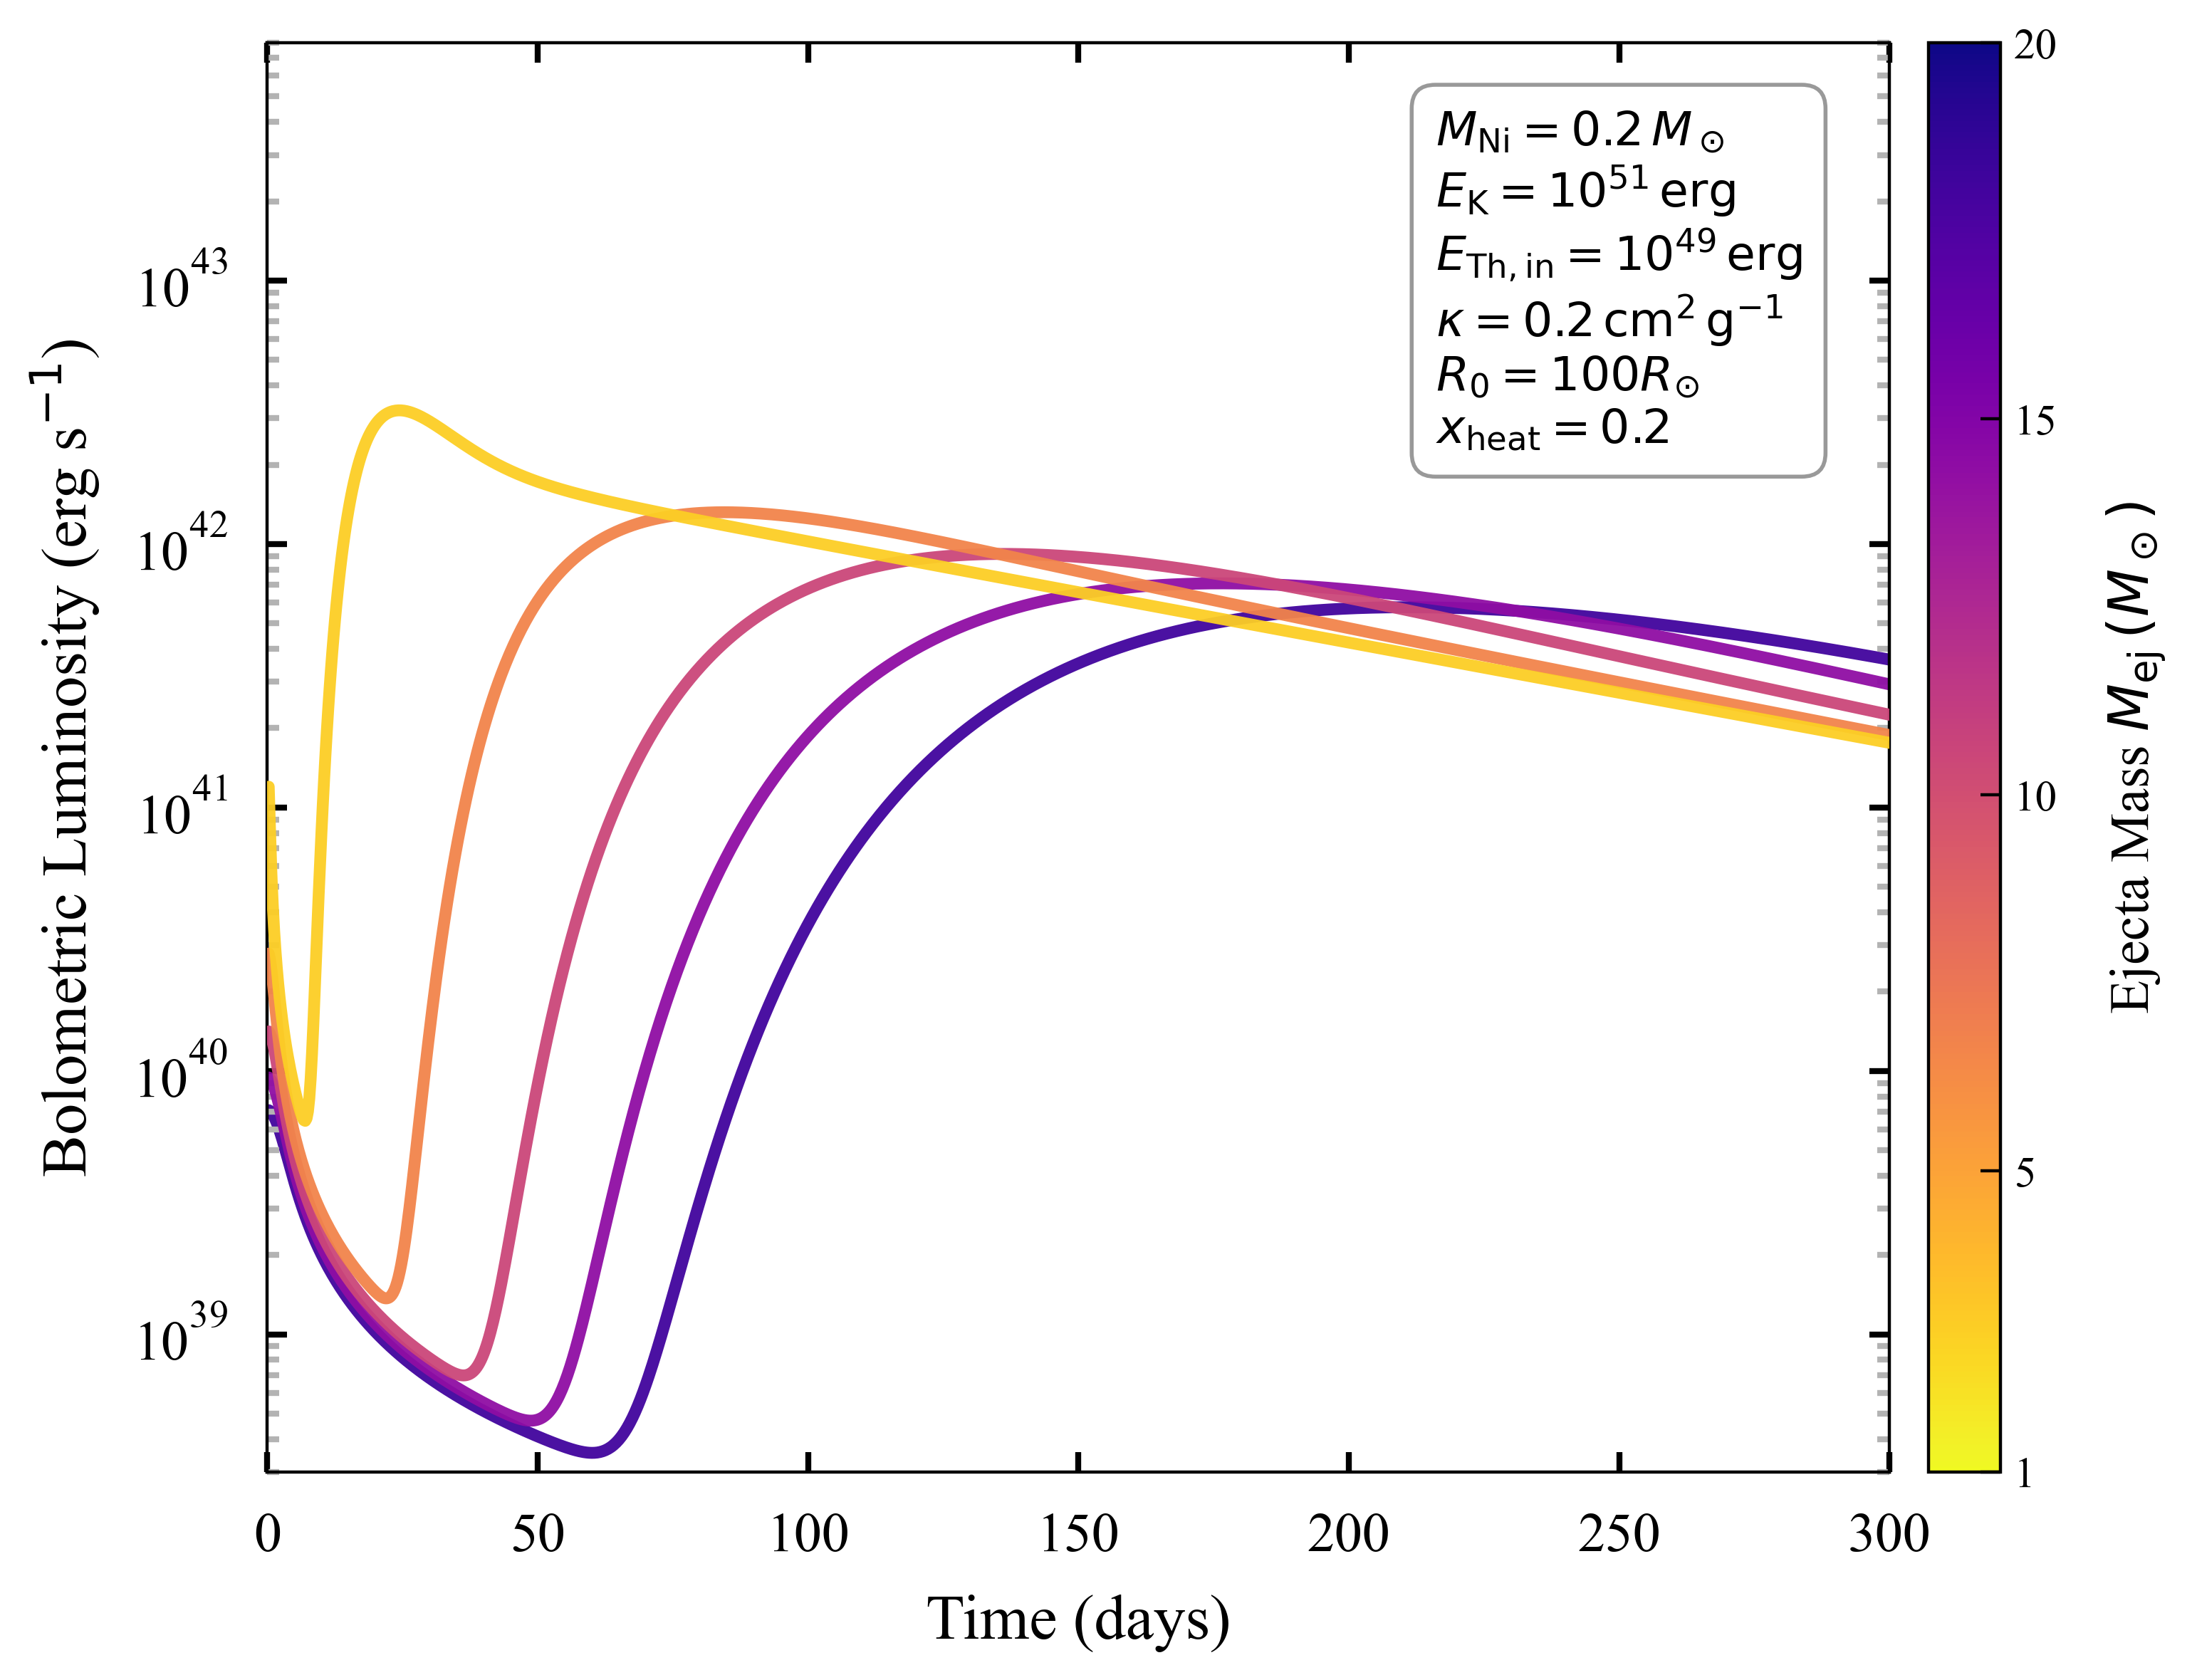

In [16]:
def plot_lc_different_M_ej(M_ej_values):
    plt.figure(figsize=(8, 6), dpi=400)
    cmap = plt.cm.plasma_r
    colors = cmap(np.linspace(0.1, 0.9, len(M_ej_values)))
    
    # 绘制曲线（保持原有顺序）
    for i, M_ej in enumerate(sorted(M_ej_values)):
        sn = SupernovaLightCurve()
        t, L_bol, *_ = sn.calculate_light_curve(M_ej=M_ej)
        plt.plot(t, L_bol, lw=3.0, 
                color=colors[i], 
                alpha=0.95,
                solid_capstyle='round',
                zorder=len(M_ej_values)-i)

    # 坐标轴设置（新增刻度方向参数）
    plt.yscale('log')
    # plt.xscale('log')
    plt.xlim(0., 3e2)
    plt.ylim(3e38, 8e43)
    plt.xlabel("Time (days)", fontsize=16, labelpad=8)
    plt.ylabel(r"Bolometric Luminosity (erg s$^{-1}$)", fontsize=16, labelpad=8)
    

    # 颜色条设置（添加刻度方向）
    M_ej_solar = np.array(M_ej_values)/M_sun
    norm = mcolors.Normalize(vmin=min(M_ej_solar ), vmax=max(M_ej_solar ))
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
    cbar.set_label(r"Ejecta Mass $M_{\rm ej}\,(M_\odot)$", fontsize=14, labelpad=12)
    cbar.set_ticks(M_ej_solar)
    cbar.ax.tick_params(
        direction='in',         # 颜色条刻度朝内
        length=5.0, 
        width=0.8,
        labelsize=11
    )
    # cbar.ax.yaxis.set_major_formatter(LogFormatterSciNotation())

    # 其他保持原有设置...
    # [参数框、网格线、输出设置等部分保持不变]
        # 参数框设置（优化排版和间距）
    params_text = (

        r"$M_{\rm Ni}=0.2\,M_\odot$" + "\n"
        + r"$E_{\rm K}=10^{51}\,{\rm erg}$" + "\n"
        + r"$E_{\rm Th,in}=10^{49}\,{\rm erg}$" + "\n"
        + r"$\kappa=0.2\,{\rm cm^2\,g^{-1}}$" + "\n"
        + r"$R_{\rm 0}=100R_{\odot}$" + "\n"
        + r"$x_{\rm heat}=0.2$"
    )
    plt.annotate(params_text, 
            xy=(0.72, 0.72),  # 调整到右上方
            xycoords='axes fraction',
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

    plt.tick_params(
        axis='both', 
        which='both',
        direction='in',        # 刻度朝向图形内部
        top=True,               # 开启上侧刻度
        right=True,             # 开启右侧刻度
        labelsize=14,
        width=1.5,
        length=5,             # 主刻度长度
        pad=10                 # 标签与刻度间距
    )
    plt.tick_params(
        which='minor', 
        direction='in',         # 次刻度同样朝内
        length=3,               # 次刻度稍短
        color='0.7'             # 灰色次刻度
    )


    # # 网格线优化（主次网格）
    # plt.grid(True, which='major', ls='-', alpha=0.5, lw=1.2)
    # plt.grid(True, which='minor', ls=':', alpha=0.3, lw=0.8)
    
    plt.tight_layout()
    plt.savefig("lc_different_M_ej.pdf", 
               dpi=1000, 
               bbox_inches='tight', 
               metadata={'CreationDate': None})
    plt.show()

M_ej_values = [1*M_sun, 5*M_sun, 10*M_sun, 15*M_sun,20*M_sun]
plot_lc_different_M_ej(M_ej_values)

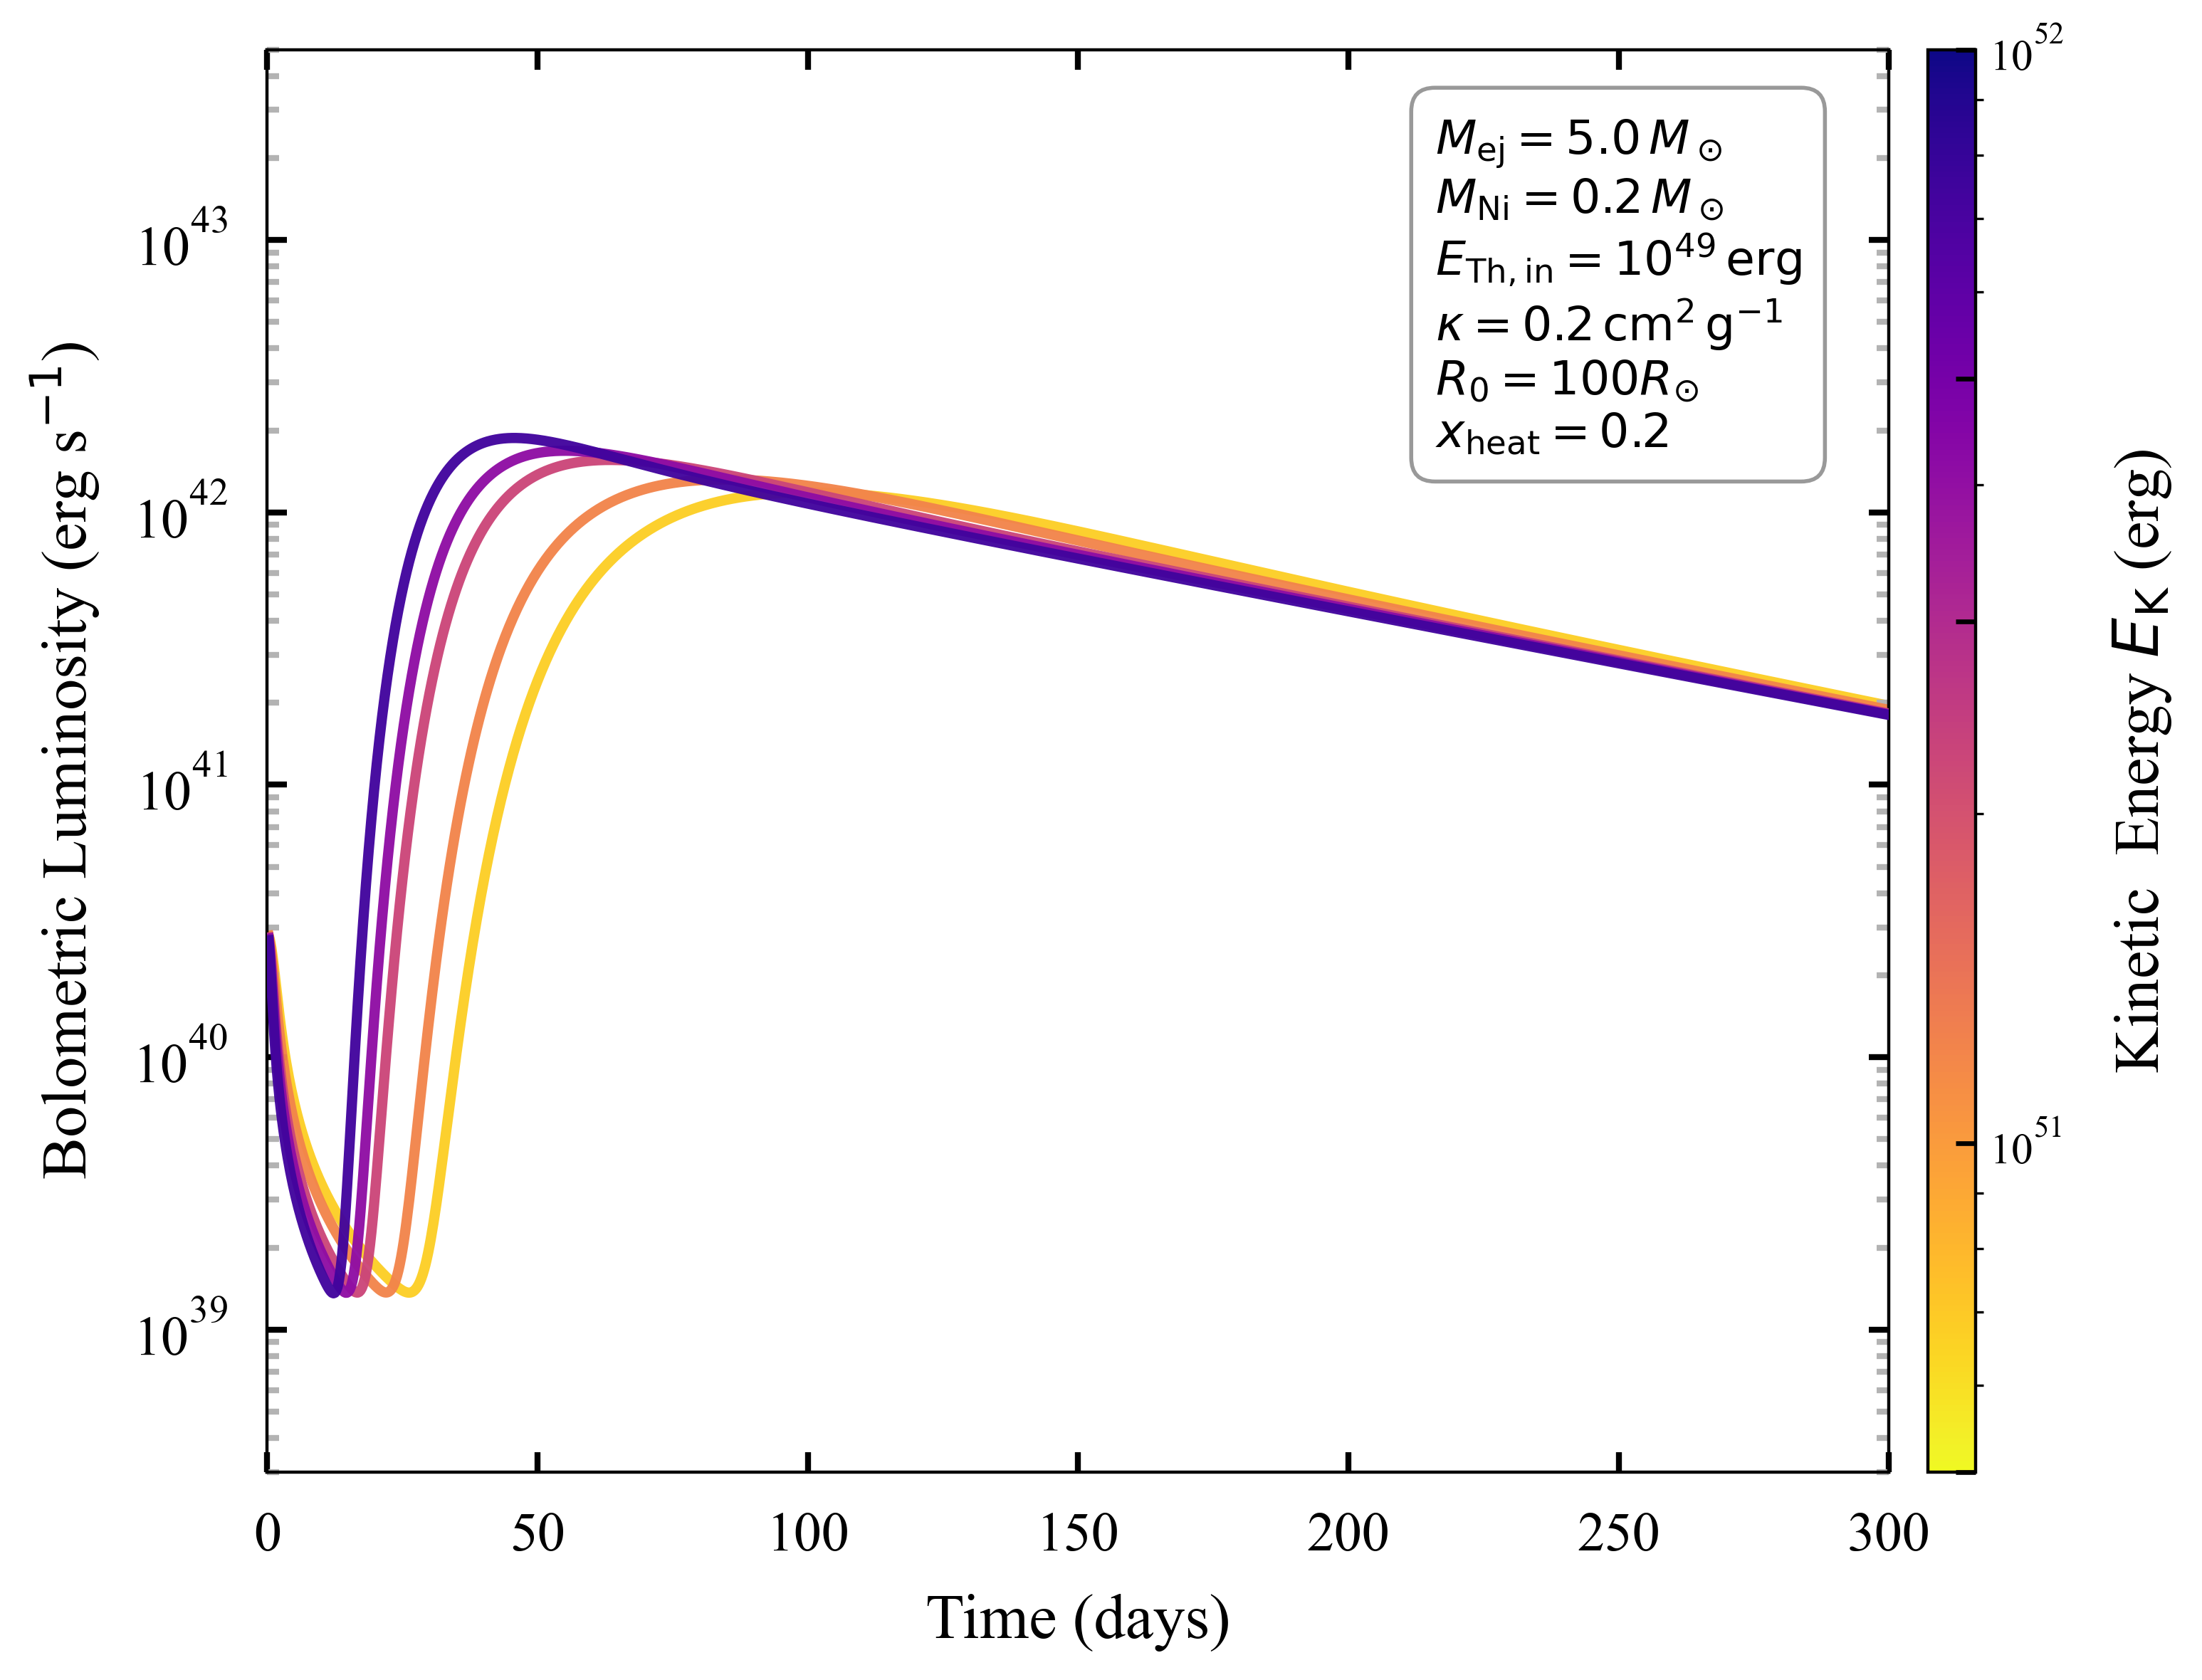

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.ticker import LogFormatterSciNotation
from matplotlib.colors import LogNorm

def plot_lc_different_E_K(E_K_values):
    plt.figure(figsize=(8, 6), dpi=400)
    colormap = plt.cm.plasma_r  # 恢复plasma色系保证对比度
    colors = colormap(np.linspace(0.1, 0.9, len(E_K_values)))
    
    # 绘制曲线（按动能升序排列）
    for i, E_K in enumerate(sorted(E_K_values)):
        sn = SupernovaLightCurve()
        t, L_bol, *_ = sn.calculate_light_curve(E_K=E_K)
        plt.plot(t, L_bol, 
                 lw=2.6,
                 color=colors[i],
                 alpha=0.96,
                 zorder=i+1,
                 solid_joinstyle='round')

    # 坐标轴系统（优化显示范围）
    plt.yscale('log')
    # plt.xscale('log')
    plt.xlim(0., 3e2)
    plt.ylim(3e38, 5e43)
    plt.xlabel("Time (days)", fontsize=16, labelpad=8)
    plt.ylabel(r"Bolometric Luminosity (erg s$^{-1}$)", fontsize=16, labelpad=8)


    # 颜色条系统（对数归一化）
    norm = LogNorm(vmin=min(E_K_values), vmax=max(E_K_values))
    sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02, aspect=30)
    cbar.set_label(r"Kinetic  Energy $E_{\rm K}$ (erg)", fontsize=16, labelpad=12)
    cbar.set_ticks(E_K_values)
    cbar.ax.tick_params(
        direction='in',         # 颜色条刻度朝内
        length=5.0, 
        width=1.2,
        labelsize=11
    )


    params_text = (
        r"$M_{\rm ej}=5.0\,M_\odot$" + "\n"
        +r"$M_{\rm Ni}=0.2\,M_\odot$" + "\n"
        + r"$E_{\rm Th,in}=10^{49}\,{\rm erg}$" + "\n"
        + r"$\kappa=0.2\,{\rm cm^2\,g^{-1}}$" + "\n"
         + r"$R_{\rm 0}=100R_{\odot}$" + "\n"
        + r"$x_{\rm heat}=0.2$"
    )
    plt.annotate(params_text, 
        xy=(0.72, 0.72),  # 调整到右上方
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

    plt.tick_params(
        axis='both', 
        which='both',
        direction='in',        # 刻度朝向图形内部
        top=True,               # 开启上侧刻度
        right=True,             # 开启右侧刻度
        labelsize=14,
        width=1.5,
        length=5,             # 主刻度长度
        pad=10                 # 标签与刻度间距
    )
    plt.tick_params(
        which='minor', 
        direction='in',         # 次刻度同样朝内
        length=3,               # 次刻度稍短
        color='0.7'             # 灰色次刻度
    )


    # # 网格线优化（主次网格）
    # plt.grid(True, which='major', ls='-', alpha=0.5, lw=1.2)
    # plt.grid(True, which='minor', ls=':', alpha=0.3, lw=0.8)
    
    plt.tight_layout()

    plt.savefig("lc_different_E_K.pdf", 
                dpi=1000, 
                bbox_inches='tight',
                )
    plt.show()
# 使用示例（典型核心坍缩超新星参数）
E_K_values = [0.5e51, 1e51, 3e51, 5e51,1e52]  # 单位：erg
plot_lc_different_E_K(E_K_values)
         

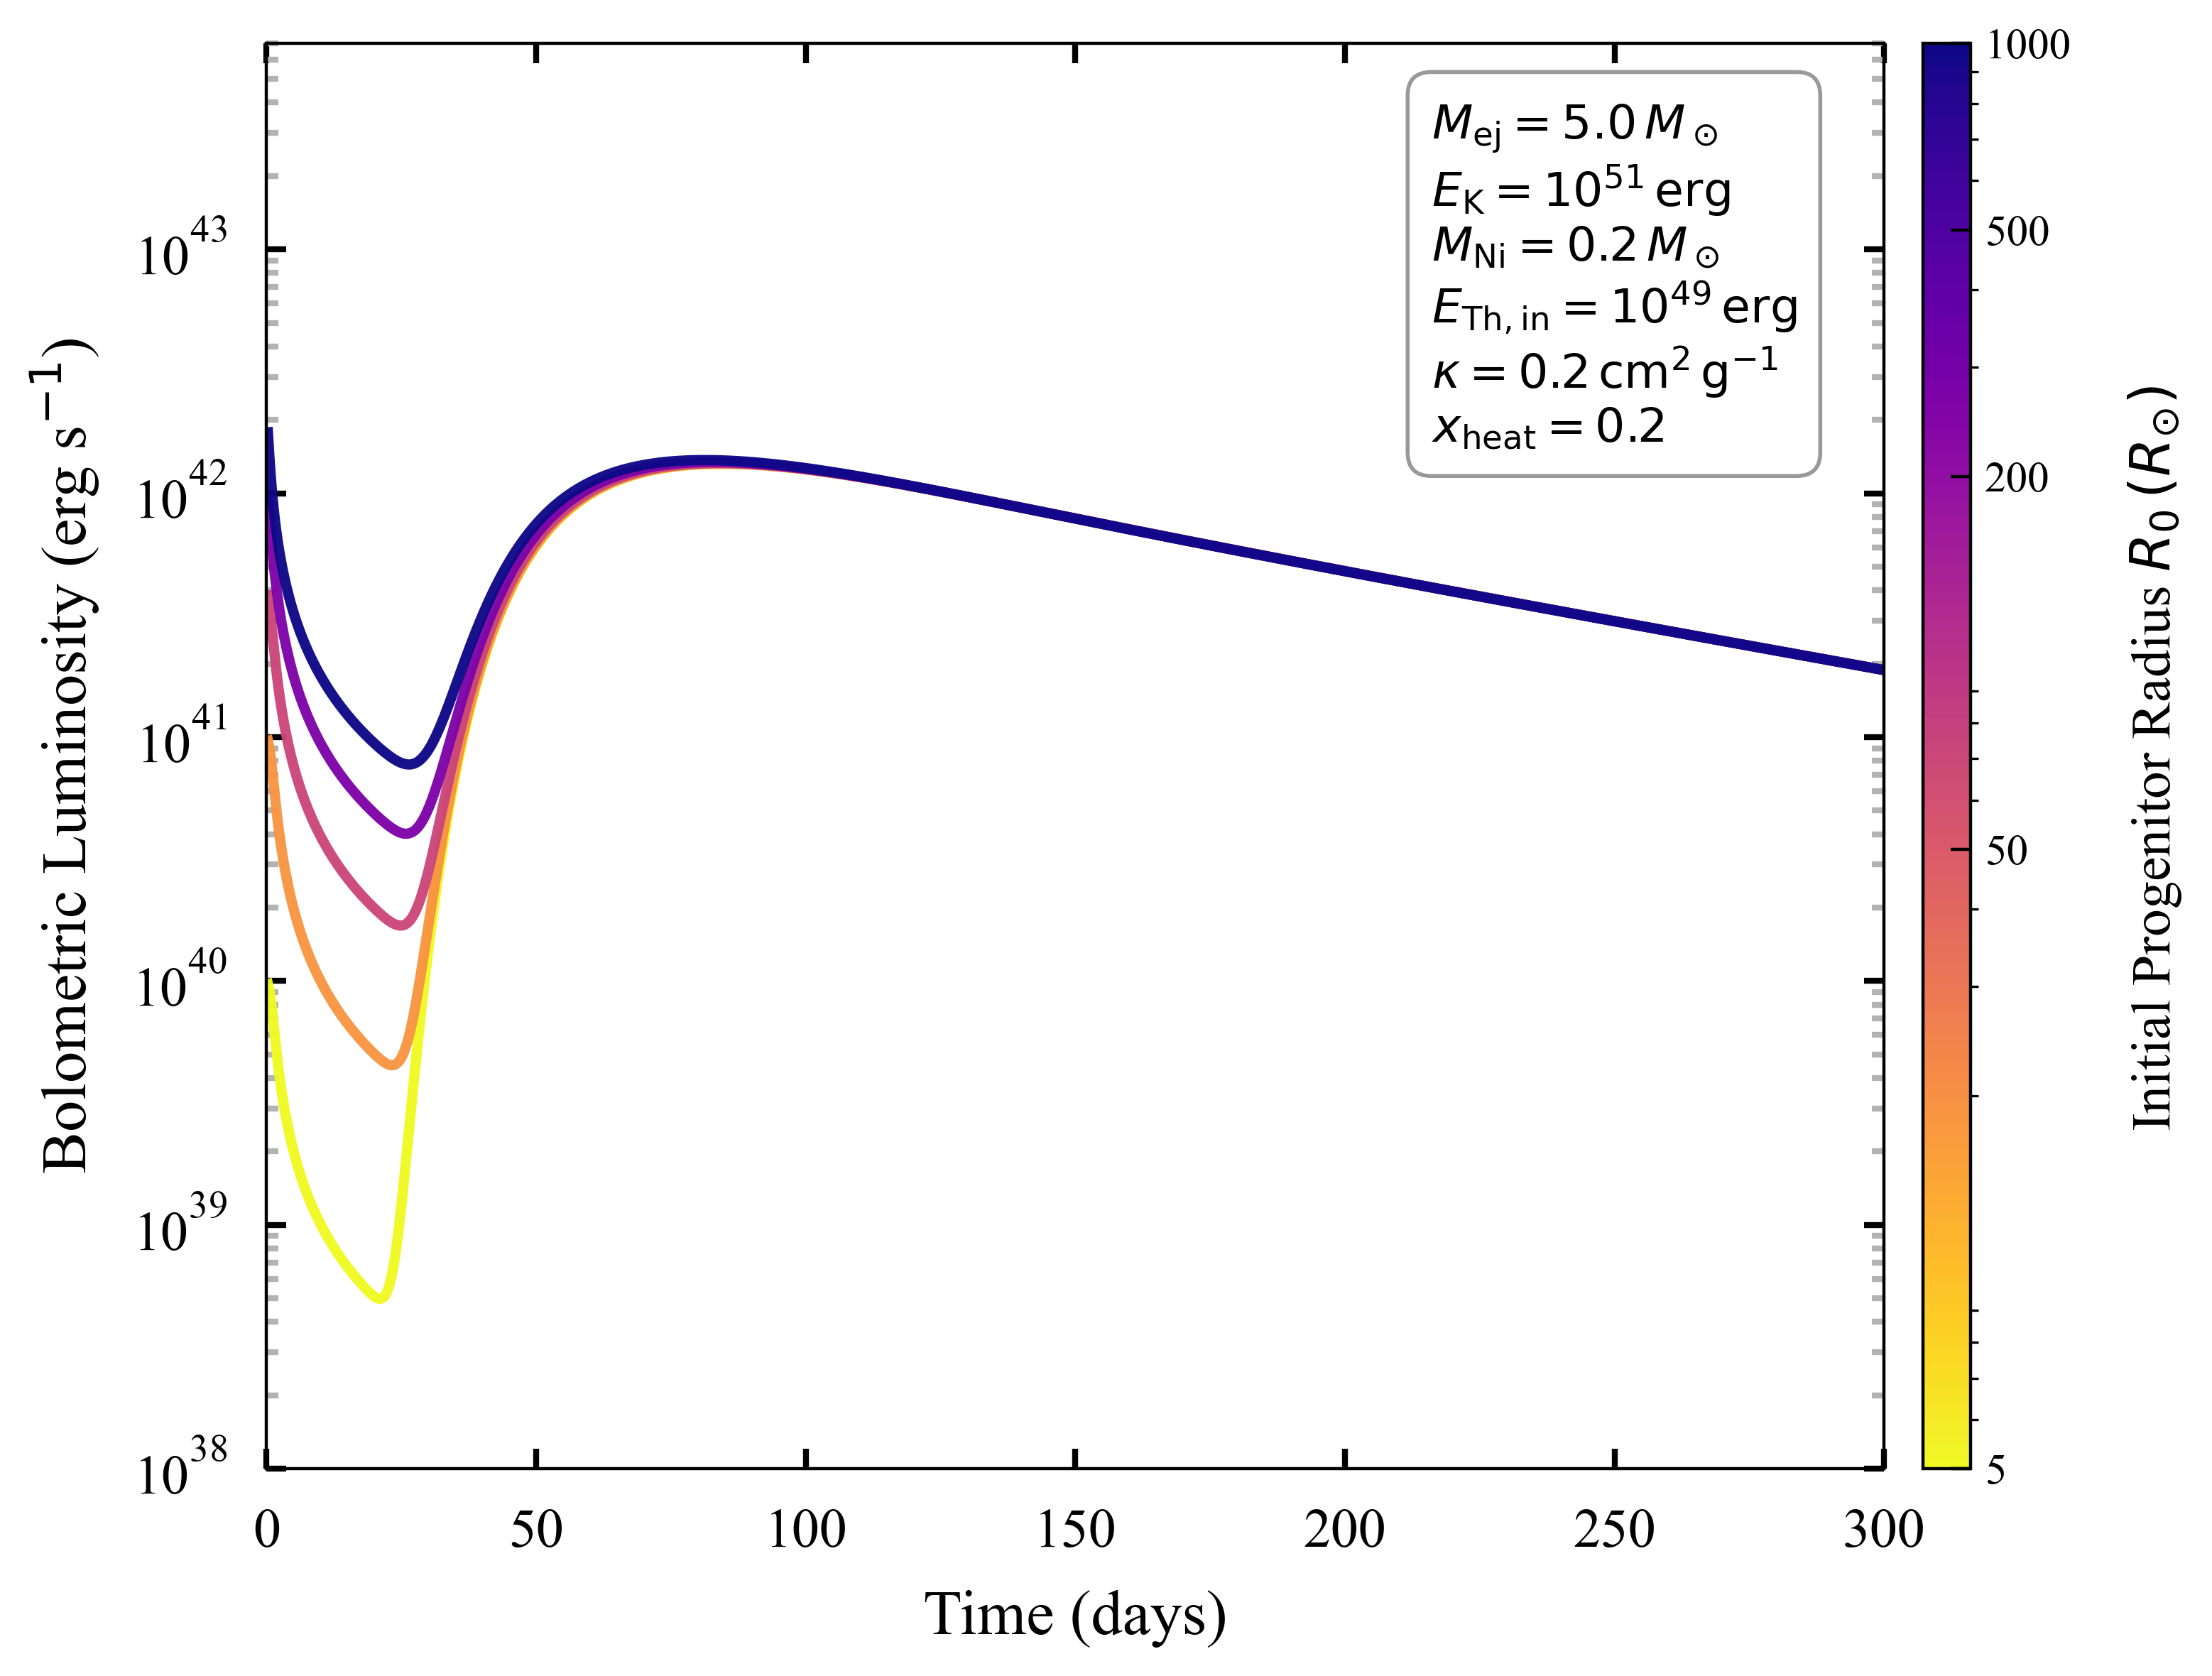

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.ticker import LogFormatterSciNotation
from matplotlib.colors import LogNorm

# Assume SupernovaLightCurve class and R_sun are defined elsewhere


def plot_lc_different_R_max(R_0_values):
    plt.figure(figsize=(8, 6), dpi=400)

    R_0_solar = np.array(R_0_values)/R_sun
    # --- KEY CHANGE HERE ---
    # Use the reversed colormap
    # colormap = plt.cm.plasma
    colormap = plt.cm.plasma_r
    # --- END OF KEY CHANGE ---

    # Generate colors using the *same* (now reversed) colormap
    # The np.linspace range might need adjustment depending on desired color spread
    # Using 0.0 to 1.0 covers the full reversed range
    colors = colormap(np.linspace(0, 1, len(R_0_solar)))

    # 绘制曲线（按动能升序排列）
    # Sort R_0_values to ensure consistent mapping from value to color index
    sorted_R_0_values = sorted(R_0_values)
    for i, R_max_in in enumerate(sorted_R_0_values):
        sn = SupernovaLightCurve()
        t, L_bol, *_ = sn.calculate_light_curve(R_max_in=R_max_in)
        plt.plot(t, L_bol,
                 lw=2.6,
                 # Use the color corresponding to the index 'i' in the sorted list
                 color=colors[i],
                 alpha=0.96,
                 solid_joinstyle='round')

    # 坐标轴系统（优化显示范围）
    plt.yscale('log')
    # plt.xscale('log')
    plt.xlim(0., 3e2)
    plt.ylim(1e38, 7e43)
    plt.xlabel("Time (days)", fontsize=16, labelpad=8)
    plt.ylabel(r"Bolometric Luminosity (erg s$^{-1}$)", fontsize=16, labelpad=8)


    # 颜色条系统（关键修改部分）
    # Ensure the norm covers the actual range of sorted values
    norm = LogNorm(vmin=min(R_0_solar), vmax=max(R_0_solar))
    # Use the *same* reversed colormap for the ScalarMappable
    sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02, aspect=30)

    # 设置颜色条标签和刻度
    cbar.set_label(r"Initial Progenitor Radius $R_{0}\,(R_{\odot})$ ", fontsize=14, labelpad=14) # Corrected LaTeX
    # Sort the R_0_solar values for ticks to match the data range
    sorted_R_0_solar = sorted(R_0_solar)
    cbar.set_ticks(sorted_R_0_solar)  # Set ticks based on sorted values
    cbar.set_ticklabels([f"{x:.0f}" for x in sorted_R_0_solar]) # Labels match sorted ticks

    # Tick parameters remain the same, but the color scale is now inverted
    cbar.ax.tick_params(
        direction='in',          # 颜色条刻度朝内
        length=5.0,
        width=0.8,
        labelsize=11
    )
    # Optional: Invert the y-axis of the colorbar axes directly
    # This achieves the same visual effect as using cmap_r but might be needed
    # if you didn't control the colormap generation directly.
    # cbar.ax.invert_yaxis() # Uncomment this line *instead* of using cmap_r if needed

    # 参数标注框
    params_text = (
        r"$M_{\rm ej}=5.0\,M_\odot$" + "\n"
        +r"$E_{\rm K}=10^{51}\,{\rm erg}$" + "\n"
        +r"$M_{\rm Ni}=0.2\,M_\odot$" + "\n"
        + r"$E_{\rm Th,in}=10^{49}\,{\rm erg}$" + "\n"
        + r"$\kappa=0.2\,{\rm cm^2\,g^{-1}}$" + "\n"
        + r"$x_{\rm heat}=0.2$"
    )
    plt.annotate(params_text,
        xy=(0.72, 0.72),  # 调整到右上方
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

    plt.tick_params(
        axis='both',
        which='both',
        direction='in',        # 刻度朝向图形内部
        top=True,              # 开启上侧刻度
        right=True,            # 开启右侧刻度
        labelsize=14,
        width=1.5,
        length=5,              # 主刻度长度
        pad=10                 # 标签与刻度间距
    )
    plt.tick_params(
        which='minor',
        direction='in',        # 次刻度同样朝内
        length=3,              # 次刻度稍短
        color='0.7'            # 灰色次刻度
    )


    # # 网格线优化（主次网格）
    # plt.grid(True, which='major', ls='-', alpha=0.5, lw=1.2)
    # plt.grid(True, which='minor', ls=':', alpha=0.3, lw=0.8)

    plt.tight_layout()

    plt.savefig("lc_different_R0.pdf", # Changed filename
                dpi=1000,
                bbox_inches='tight',
               )
    plt.show()

# Use the original R_0_values list
R_0_values = [5*R_sun, 50*R_sun, 200*R_sun, 500*R_sun, 1000*R_sun]
plot_lc_different_R_max(R_0_values)